# モデル予測制御をMMGモデルに適用するプログラム

do_mpcを利用してMMGモデルでMPCを実施する


## MMGモデルの関数

先にMMGモデルの各種力を計算する関数を出しておく

### 船体に働く流体力について
$$
X_H=\frac{1}{2}\rho L_{pp}dU^2X'_H(\beta,r')  \\
Y_H=\frac{1}{2}\rho L_{pp}dU^2Y'_H(\beta,r')  \\
N_H=\frac{1}{2}\rho L_{pp}^2dU^2N'_H(\beta,r')  \\
\beta=tan^{-1}\left(\frac{-v}{u}\right)  \\
r'=\frac{rL_{pp}}{U}
$$

In [1]:
!python --version
print('------------------')
!jupyter --version
print('------------------')
!cat /etc/os-release #if Linux
print('------------------')
!ver #if Windows

Python 3.11.4
------------------
Selected Jupyter core packages...------------------

IPython          : 8.17.2
ipykernel        : 6.26.0
ipywidgets       : not installed
jupyter_client   : 8.5.0
jupyter_core     : 5.5.0
jupyter_server   : 2.10.0
jupyterlab       : 4.0.8
nbclient         : 0.9.0
nbconvert        : 7.11.0
nbformat         : 5.9.2
notebook         : 7.0.6
qtconsole        : not installed
traitlets        : 5.13.0
------------------


'cat' �́A�����R�}���h�܂��͊O���R�}���h�A
����\�ȃv���O�����܂��̓o�b�` �t�@�C���Ƃ��ĔF������Ă��܂���B



Microsoft Windows [Version 10.0.22621.3007]


In [2]:
import shipmmg
from shipmmg.kt import KTParams, simulate_kt
from shipmmg.mmg_3dof import (
    Mmg3DofBasicParams,
    Mmg3DofManeuveringParams,
    simulate_mmg_3dof,
    zigzag_test_mmg_3dof,
    get_sub_values_from_simulation_result,
)
from shipmmg.ship_obj_3dof import ShipObj3dof
import numpy as np
from scipy.interpolate import interp1d
import casadi as ca

In [3]:
#運動方程式を有次元値で扱っている
def X_H(u,v,r):
    U=np.sqrt(u**2+v**2)
    β=np.arctan(-v/u)
    r_dash=r*L_pp/U
    v_dash=v/U
    return 0.5*ρ*L_pp*d*U**2*X_H_dash(v_dash,r_dash)

def Y_H(u,v,r):
    U=np.sqrt(u**2+v**2)
    β=np.arctan(-v/u)
    r_dash=r*L_pp/U
    v_dash=v/U
    return 0.5*ρ*L_pp*d*U**2*Y_H_dash(v_dash,r_dash)

def N_H(u,v,r):
    U=np.sqrt(u**2+v**2)
    β=np.arctan(-v/u)
    r_dash=r*L_pp/U
    v_dash=v/U
    return 0.5*ρ*L_pp**2*d*U**2*N_H_dash(v_dash,r_dash)

### 船体に働く流体力(無次元)

操縦流体力微係数を用いて無次元の流体力を表す
$$
X'_H=R'_0+X'_{\beta\beta}\beta^2+X'_{\beta r}\beta r+X'_{rr}r'^2+X'_{\beta\beta\beta\beta}\beta^4  \\
Y'_H=Y'_{\beta}\beta+Y'_{r}r'+Y'_{\beta\beta r}\beta^2r'+Y'_{\beta rr}\beta r'^2+Y'_{\beta\beta\beta}\beta^3+Y'_{rrr}r'^3  \\
N'_H=N'_{\beta}\beta+N'_{r}r'+N'_{\beta\beta r}\beta^2r'+N'_{\beta rr}\beta r'^2+N'_{\beta\beta\beta}\beta^3+N'_{rrr}r'^3
$$

In [4]:
#斜航角ではなく横方向の速度の無次元化成分を使う？
def X_H_dash(β,r_dash):
    return -R_0_dash+X_vv_dash*β**2+X_vr_dash*β*r_dash+X_rr_dash*r_dash**2+X_vvvv_dash*β**4

def Y_H_dash(β,r_dash):
    return Y_v_dash*β+Y_r_dash*r_dash+Y_vvr_dash*β**2*r_dash+Y_vrr_dash*β*r_dash**2+Y_vvv_dash*β**3+Y_rrr_dash*r_dash**3

def N_H_dash(β,r_dash):
    return N_v_dash*β+N_r_dash*r_dash+N_vvr_dash*β**2*r_dash+N_vrr_dash*β*r_dash**2+N_vvv_dash*β**3+N_rrr_dash*r_dash**3

### 舵に働く力

舵に働く力を表す数式

$$
X_R=-(1-t_R)F_N(u,v,\delta,n_p)\sin(\delta)  \\
Y_R=-(1+a_H)F_N(u,v,\delta,n_p)\cos(\delta)  \\
N_R=-(x_R+a_Hx_H)F_N(u,v,\delta,n_p)\cos(\delta)  \\
F_N=\frac{1}{2}\rho A_Ru_R^2f_{\alpha}\alpha_R  \\
u_p=(1-w_{P0}u  \\
u_\infty=u_p \sqrt{1+\frac{8K_T}{\pi J^2}}  \\
\kappa=\frac{k_x}{\varepsilon_w}  \\
u_{RP}=u_p+k_x\Delta u  \\
u_R=\sqrt{\eta u_RP^2+(1-\eta)u_p^2}  \\
U=\sqrt{u^2+v^2}
v_R=U\gamma_{R+}(\beta-l_{r'}r')  \\
\alpha_R=\delta-tan^{-1}\left(\frac{v_R}{u_R}\right)
$$

In [5]:
# def X_R(u,n_p):
#     return -(1-t_R)*F_N(u,v,δ,n_p)*np.sin(δ)

def X_R(u,v,r,δ,n_p):
    return -(1-t_R)*F_N(u,v,r,δ,n_p)*np.sin(δ)

def Y_R(u,v,r,δ,n_p):
    return -(1+a_H)*F_N(u,v,r,δ,n_p)*np.cos(δ)

def N_R(u,v,r,δ,n_p):
    return -(x_R+a_H*x_H)*F_N(u,v,r,δ,n_p)*np.cos(δ)

def F_N(u,v,r,δ,n_p):
    U=np.sqrt(u**2+v**2)
    β=np.arctan(-v/U)
    r_dash=r*L_pp/U
    w_P = w_P0 * np.exp(-4.0 * (β - x_P * r_dash) ** 2)
    u_p=(1-w_P)*u
    u_R=ϵ*u_p*np.sqrt(η*(1+κ*(np.sqrt(1+(8*K_T(u,v,r,n_p))/(np.pi*J(u,v,r,n_p)**2))-1))**2+(1-η))
    v_R=U*γ_R_plus*(β-l_r_dash*r_dash)
    α_R=δ-np.arctan(v_R/u_R)
    U_R=np.sqrt(u_R**2+v_R**2)
    return 0.5*ρ*A_R*U_R**2*f_α*np.sin(α_R)

### プロペラに働く力

プロペラに働く力についての数式

$$
X_P=(1-t_P)T_P(u,n_p)  \\
K_T=k_0+k_1J(u,n_p)+k_2J(u,n_p)^2  \\
J(u,n_p)=u\frac{1-w_{P0}}{n_pD_p}  \\
T_P(u,n_p)=K_T\rho n_p^2D_p^4
$$

In [6]:
def X_P(u,v,r,δ,n_p):
    return (1-t_P)*T_P(u,v,r,n_p)

def K_T(u,v,r,n_p):
    return k_0+k_1*J(u,v,r,n_p)+k_2*J(u,v,r,n_p)**2

def J(u,v,r,n_p):
    U=np.sqrt(u**2+v**2)
    β=np.arctan(-v/U)
    r_dash=r*L_pp/U
    w_P = w_P0 * np.exp(-4.0 * (β - x_P * r_dash) ** 2)
    return u*(1-w_P)/(n_p*D_p)

def T_P(u,v,r,n_p):
    return K_T(u,v,r,n_p)*ρ*n_p**2*D_p**4

## MPCプログラム
ここからモデル予測制御についてのプログラム

In [7]:
import numpy as np
import do_mpc
from casadi import vertcat

import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
# Customizing Matplotlib:
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.grid'] = True

c:\Users\yamamoto\AppData\Local\Programs\Python\Python311\Lib\site-packages\do_mpc\sysid\__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
c:\Users\yamamoto\AppData\Local\Programs\Python\Python311\Lib\site-packages\do_mpc\opcua\__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


## モデルの作成

モデルのタイプとして'discrete'(離散的)か'continuous'(連続的)かを選択する

In [8]:
model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

## 変数の設定

### 入出力の変数設定

- 状態量 : var_type='_x'
- 操作量 : var_type='_u'

操作量は舵角$\delta$とプロペラ回転数$n_p$  
状態量は$x,y,u,v,r,\psi$


$\delta$ : 舵角  
$n_p$ : プロペラ回転数  
$u$ : 船首方向の船速  
$v$ : 横方向の船速  
$r$ : 旋回角速度  
$x,y$ : 船の座標  
$\psi$ : 船首角(船首とx軸正の向きの角度)

In [9]:
X_F = model.set_variable(var_type='_u', var_name='X_F', shape=(1,1)) #x方向の外力
Y_F = model.set_variable(var_type='_u', var_name='Y_F', shape=(1,1)) #y方向の外力
N_F = model.set_variable(var_type='_u', var_name='N_F', shape=(1,1)) #外力による回頭モーメント

u = model.set_variable(var_type='_x', var_name='u', shape=(1,1)) #前後方向速度
v = model.set_variable(var_type='_x', var_name='v', shape=(1,1)) #横方向速度
r = model.set_variable(var_type='_x', var_name='r', shape=(1,1)) #回頭角速度
x = model.set_variable(var_type='_x', var_name='x', shape=(1,1)) #船のx座標
y = model.set_variable(var_type='_x', var_name='y', shape=(1,1)) #船のy座標
ψ = model.set_variable(var_type='_x', var_name='ψ', shape=(1,1)) #船首角(x軸正の方向となす角)
X_F_m = model.set_variable(var_type='_x', var_name='X_F_m', shape=(1,1)) 
Y_F_m = model.set_variable(var_type='_x', var_name='Y_F_m', shape=(1,1)) 
N_F_m = model.set_variable(var_type='_x', var_name='N_F_m', shape=(1,1)) 

x_ref=model.set_variable(var_type='_tvp',var_name='x_ref',shape=(1,1))
y_ref=model.set_variable(var_type='_tvp',var_name='y_ref',shape=(1,1))
psi_ref=model.set_variable(var_type='_tvp',var_name='psi_ref',shape=(1,1))
u_ref=model.set_variable(var_type='_tvp',var_name='u_ref',shape=(1,1))
v_ref=model.set_variable(var_type='_tvp',var_name='v_ref',shape=(1,1))
r_ref=model.set_variable(var_type='_tvp',var_name='r_ref',shape=(1,1))

### 舵角とプロペラ回転数

In [ ]:
δ_ref = -35 * np.pi/ 180.0
n_p_ref = 9.0

### パラメータの設定

時間によって変化しないパラメータを設定する
- 不確定性を与えない場合は'model.set_variable()'としなくてもいいらしい

In [10]:
#Suzaku-model
ρ = 1025.0  # 海水密度

nabla = 0.231  # 排水量[m3] Lpp*B:d*Cb
L_pp = 3.50  # 船長Lpp[m]
B = 0.57  # 船幅[m]
d = 0.16  # 喫水[m]
x_G = 0.0112  # 重心位置[]
C_b = 0.72368 # 方形係数
D_p = 0.03373 * L_pp #0.120  # プロペラ直径[m]
m = 1025 * nabla  # 質量(無次元化)[kg]
# I_zG = 1025 * nabla * ((0.25 * L_pp)^2)  # 慣性モーメント[-]  kg/m3 * m3 *m2
A_R = 0.0189  # 船の断面に対する舵面積比[-]
# H_R = 0.1495  # 舵高さ[m]
η = 0.8023  # プロペラ直径に対する舵高さ(Dp/H)
m_x_dash = 0.0475 # 付加質量x(無次元) kg/m3 * m2 * m /kg
m_y_dash = 0.6739 # 付加質量y(無次元)
J_z_dash = 0.0306 # 付加質量Izz(無次元)
f_α = 2.634 # 直圧力勾配係数
ϵ = 1.345  # プロペラ・舵位置伴流係数比
t_R = 0.084  # 操縦抵抗減少率 
a_H = 0.054  # 舵力増加係数
x_H = -0.388 * L_pp  # 舵力増分作用位置
γ_R_minus = 0.225 # 整流係数
γ_R_plus = 0.574  # 整流係数
l_r_dash = -0.641  # 船長に対する舵位置
κ = 0.482  # 修正係数
t_P = 0.180  # 推力減少率 #モデルの違い
w_P0 = 0.40  # 有効伴流率 #モデルの違い
x_P = -0.490  # 船長に対するプロペラ位置 #モデルの違い
x_R = -0.500 * L_pp
I_zG=ρ * nabla * ((0.25 * L_pp) ** 2)
m_x=(0.5 * ρ * (L_pp ** 2) * d) * m_x_dash  # 付加質量x(無次元)
m_y=(0.5 * ρ * (L_pp ** 2) * d) * m_y_dash  # 付加質量y(無次元)
J_z=(0.5 * ρ * (L_pp ** 4) * d) * J_z_dash  # 付加質量Izz(無次元)

basic_params = Mmg3DofBasicParams(
    L_pp=L_pp,  # 船長Lpp[m]
    B=B,  # 船幅[m]
    d=d,  # 喫水[m]
    x_G=x_G,  # 重心位置[]
    D_p=D_p,  # プロペラ直径[m]
    m=ρ * nabla,  # 質量(無次元化)[kg]
    I_zG=ρ * nabla * ((0.25 * L_pp) ** 2),  # 慣性モーメント
    A_R=A_R,  # 船の断面に対する舵面積比
    η=η,  # プロペラ直径に対する舵高さ(Dp/H)
    m_x=m_x,  # 付加質量x(無次元)
    m_y=m_y,  # 付加質量y(無次元)
    J_z=J_z,  # 付加質量Izz(無次元)
    f_α=f_α,
    ϵ=ϵ,  # プロペラ・舵位置伴流係数比
    t_R=t_R,  # 操縦抵抗減少率
    x_R=-0.500 * L_pp,  # 舵の相対位置
    a_H=a_H,  # 舵力増加係数
    x_H=-0.388 * L_pp,  # 舵力増分作用位置
    γ_R_minus=γ_R_minus,  # 整流係数
    γ_R_plus=γ_R_plus,  # 整流係数
    l_R=l_r_dash,  # 船長に対する舵位置
    x_P=x_P,  # 船長に対するプロペラ位置
    κ=κ,  # 修正係数
    t_P=t_P,  # 推力減少率
    w_P0=w_P0,  # 有効伴流率
)

k_0 = 0.3516
k_1 = -0.3624
k_2 = -0.1100
R_0_dash = 0.020
X_vv_dash = -0.07993
X_vr_dash = 0.10163
X_rr_dash = -0.01487
X_vvvv_dash = 0.57037
Y_v_dash = -0.3384 #-0.37112
Y_r_dash = 0.1976 #0.07203
Y_vvv_dash = -1.05345
Y_vvr_dash = 0.20726
Y_vrr_dash = -0.25560
Y_rrr_dash = 0.02196
N_v_dash = -0.1377 #-0.10969
N_r_dash = -0.0992#-0.04994
N_vvv_dash = -0.05329
N_vvr_dash = -0.28770
N_vrr_dash = -0.02059
N_rrr_dash = -0.01959

maneuvering_params = Mmg3DofManeuveringParams(
    k_0=k_0,
    k_1=k_1,
    k_2=k_2,
    R_0_dash=R_0_dash,
    X_vv_dash=X_vv_dash,
    X_vr_dash=X_vr_dash,
    X_rr_dash=X_rr_dash,
    X_vvvv_dash=X_vvvv_dash,
    Y_v_dash=Y_v_dash,
    Y_r_dash=Y_r_dash,
    Y_vvv_dash=Y_vvv_dash,
    Y_vvr_dash=Y_vvr_dash,
    Y_vrr_dash=Y_vrr_dash,
    Y_rrr_dash=Y_rrr_dash,
    N_v_dash=N_v_dash,
    N_r_dash=N_r_dash,
    N_vvv_dash=N_vvv_dash,
    N_vvr_dash=N_vvr_dash,
    N_vrr_dash=N_vrr_dash,
    N_rrr_dash=N_rrr_dash,
)

### 微分方程式の設定

$
\displaystyle
% \dot{u}=\frac{X_H+X_R+X_P+X_F+(m+m_y)vr+x_Gmr^2}{m+m_x}  \\
\dot{u}=\frac{X_H+X_R+X_P+X_F+(m+m_y)vr}{m+m_x}  \\
\displaystyle
% \dot{v}=\frac{Y_H+Y_R+Y_F-(m+m_x)ur-x_Gm\dot{r}}{m+m_y}  \\
\dot{v}=\frac{Y_H+Y_R+Y_F-(m+m_x)ur}{m+m_y}  \\
\displaystyle
% \dot{r}=\frac{N_H+N_R+N_F-x_Gm(\dot{v_m}+ur)}{I_Z+x_G^2m+J_Z}  \\
\dot{r}=\frac{N_H+N_R+N_F}{I_Z+J_Z}  \\
\displaystyle
\dot{x}=u\cos{\psi}-v\sin{\psi}  \\
\displaystyle
\dot{y}=u\sin{\psi}+v\cos{\psi}  \\
\displaystyle
\dot{\psi}=r  \\
$

In [11]:
model.set_rhs('u', (X_H(u,v,r)+X_R(u,v,r,δ_ref,n_p_ref)+X_P(u,v,r,δ_ref,n_p_ref)+X_F_m+(m+m_y)*v*r)/(m+m_x))
model.set_rhs('v', (Y_H(u,v,r)+Y_R(u,v,r,δ_ref,n_p_ref)+Y_F_m-(m+m_x)*u*r)/(m+m_y))
model.set_rhs('r', (N_H(u,v,r)+N_R(u,v,r,δ_ref,n_p_ref)+N_F_m)/(I_zG+J_z))
# model.set_rhs('u', (X_H(u,v,r)+X_R(u,v,δ_ref,n_p_ref)+X_P(u,v,δ_ref,n_p_ref)+X_F_m+(m+m_y)*v*r+x_G*m*r**2)/(m+m_x))
# model.set_rhs('v', (x_G**2*m**2*u*r-(N_H(u,v,r)+N_R(u,v,δ_ref,n_p_ref)+N_F_m)*x_G*m+(Y_H(u,v,r)+Y_R(u,v,δ_ref,n_p_ref)+Y_F_m-(m+m_x)*u*r)*(I_zG+J_z+x_G**2*m))/((I_zG+J_z+x_G**2*m)*(m+m_y)-x_G**2*m**2))
# model.set_rhs('r', (N_H(u,v,r)+N_R(u,v,δ_ref,n_p_ref)+N_F_m-x_G*m*((x_G**2*m**2*u*r-(N_H(u,v,r)+N_R(u,v,δ_ref,n_p_ref)+N_F_m)*x_G*m+(Y_H(u,v,r)+Y_R(u,v,δ_ref,n_p_ref)+Y_F_m-(m+m_x)*u*r)*(I_zG+J_z+x_G**2*m))/((I_zG+J_z+x_G**2*m)*(m+m_y)-x_G**2*m**2)+u*r))/(I_zG+J_z+x_G**2*m))
model.set_rhs('x', u * np.cos(ψ) - v * np.sin(ψ))
model.set_rhs('y', u * np.sin(ψ) + v * np.cos(ψ))
model.set_rhs('ψ', r)
model.set_rhs('X_F_m', (X_F - X_F_m))
model.set_rhs('Y_F_m', (Y_F - Y_F_m))
model.set_rhs('N_F_m', (N_F - N_F_m))

In [12]:
model.setup()

## MPCコントローラの形成

n_horizon、t_step、n_robustを設定する。  

In [13]:
mpc = do_mpc.controller.MPC(model)

run_time=130 #実行時間[s]
n_horizon = 70 #予測ステップ数
t_step = 1.0 #制御周期[s]
n_robust = 1 # default to 0 予測ホライズン区間
store_full_solution = True

setup_mpc = {
    'n_horizon': n_horizon,
    't_step': t_step,
    'n_robust': n_robust,
    'store_full_solution': store_full_solution,
}

mpc.set_param(**setup_mpc)

## 目標軌道の設定
MPCの目標軌道として円軌道を作成する

In [14]:
csv_input = pd.read_csv('observation/suzaku_obs.csv') #csvファイル名変更
csv_input = csv_input.drop(['Unnamed: 0'], axis=1)
csv_input

,time_list,x,y,psi,u,v,r,δ,npm,X_H_ref,X_R_ref,X_P_ref,Y_H_ref,Y_R_ref,N_H_ref,N_R_ref,x_bow,y_bow,x_stern,y_stern
0,0,29.130462,-3.546608,2.317656,0.232522,0.055359,0.000000,-0.610865,9.0,-0.371325,-3.141784,3.905840,-1.499703,4.486932,-1.868243,-8.931405,27.941621,-2.262413,30.319302,-4.830804
1,1,29.130462,-3.546608,2.317656,0.232522,0.055359,-0.093890,-0.610865,9.0,-1.363525,-3.156565,3.548255,-8.977736,4.508042,9.582889,-8.973426,27.941621,-2.262413,30.319302,-4.830804
2,2,28.931877,-3.413585,2.223766,0.222723,0.065243,-0.093053,-0.610865,9.0,-1.425130,-3.099885,3.591050,-9.602237,4.427094,9.413883,-8.812296,27.868668,-2.023589,29.995085,-4.803581
3,3,28.744740,-3.276318,2.130713,0.213232,0.069687,-0.086718,-0.610865,9.0,-1.334607,-3.068045,3.638275,-9.113513,4.381622,8.302411,-8.721781,27.815287,-1.793545,29.674193,-4.759092
4,4,28.572443,-3.132658,2.043995,0.207874,0.061268,-0.083157,-0.610865,9.0,-1.189005,-3.065536,3.667757,-7.963368,4.378039,7.593772,-8.714648,27.774905,-1.574957,29.369981,-4.690360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,196,33.450558,-1.193997,-12.189880,0.172429,0.068028,-0.074270,-0.610865,9.0,-1.006501,-2.923346,3.837111,-7.274180,4.174971,6.193408,-8.310434,35.077989,-0.550593,31.823127,-1.837401
197,197,33.611658,-1.102310,-12.264149,0.171451,0.070748,-0.077355,-0.610865,9.0,-1.065723,-2.904698,3.840794,-7.860213,4.148339,6.724757,-8.257422,35.282344,-0.581437,31.940972,-1.623183
198,198,33.777958,-1.020182,-12.341504,0.171127,0.073940,-0.078290,-0.610865,9.0,-1.096772,-2.895067,3.841967,-8.249921,4.134585,6.944665,-8.230044,35.483900,-0.629974,32.072016,-1.410390
199,199,33.949815,-0.947955,-12.419795,0.000000,0.000000,0.000000,-0.610865,9.0,-0.000000,-0.000514,4.649531,0.000000,0.000735,-0.000000,-0.001462,35.681050,-0.692365,32.218580,-1.203545


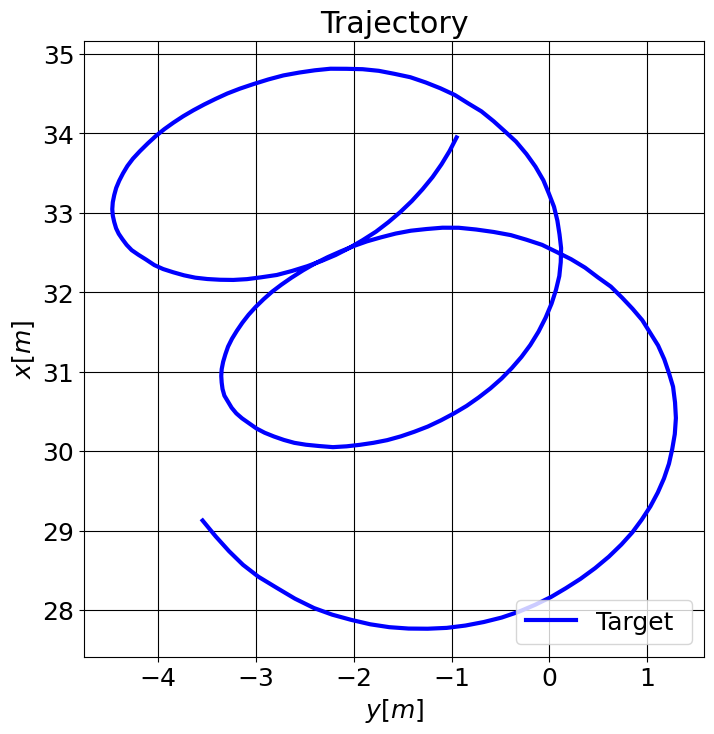

In [15]:
# 目標軌道の設定
fig=plt.figure(figsize=(8.0,8.0))
plt.plot(csv_input['y'][0:200],csv_input['x'][0:200],label="Target ",c="b")
plt.legend(loc='lower right')
plt.grid(which='major',color='black',linestyle='-')
plt.grid(which='minor',color='black',linestyle='-')
plt.xlabel("$y[m]$")
plt.ylabel("$x[m]$")
plt.show()

### 評価関数の設定

$
C=\sum_{k=0}^{n-1}(\underbrace{l\left(x_{k}, u_{k}, z_{k}, p\right)}_{\text {lagrange term }}+\underbrace{\Delta u_{k}^{T} R \Delta u_{k}}_{\text {r-term }})+\underbrace{m\left(x_{n}\right)}_{\text {meyer term }}
$

今回は、目標軌道を追従するような目的関数を設定する

時刻kごとに目標座標$x_k^{ref},y_k^{ref}$を変化させることで軌道追従ができる 

$lagrange term=\sum_{k=0}^{n-1}((x_k-x_k^{ref})^2+(y_k-y_k^{ref})^2+(\psi_k-\psi_k^{ref})^2)$  
$r-term=\Delta u_k^TR\Delta u_k$  
$meyer=(x_n-x_n^{ref})^2+(y_n-y_n^{ref})^2+(\psi_n-\psi_n^{ref})^2$

In [16]:
lterm=(model.x['x']-model.tvp['x_ref'])**2+(model.x['y']-model.tvp['y_ref'])**2+(model.x['ψ']-model.tvp['psi_ref'])**2
mterm=lterm
# mpc.set_objective(mterm=mterm,lterm=lterm)
mpc.set_objective(mterm=mterm,lterm=lterm)

$\Delta u_k^TR\Delta u_k$の設定

In [17]:
mpc.set_rterm(
    X_F = 1e-5,
    Y_F = 1e-5,
    N_F = 1e-6
)

In [18]:
tvp_template = mpc.get_tvp_template()

## 時間ごとに目標とする座標を変更する関数
MPCでの関数名とsimulatorでの関数名を異なるものにする必要がある(同じだとエラーが発生する)  
現状、プログラムを回すたびに$x_{ref}$,$y_{ref}$を変更しなければならない

In [19]:
# 3dof z試験
def tvp_fun(t_now):
    for k in range(n_horizon):
        tvp_template['_tvp',k,'x_ref']=np.array([csv_input['x'][int(t_now+k)]])
        tvp_template['_tvp',k,'y_ref']=np.array([csv_input['y'][int(t_now+k)]])
        tvp_template['_tvp',k,'psi_ref']=np.array([csv_input['psi'][int(t_now+k)]])
        tvp_template['_tvp',k,'u_ref']=np.array([csv_input['u'][int(t_now+k)]])
        tvp_template['_tvp',k,'v_ref']=np.array([csv_input['v'][int(t_now+k)]])
        tvp_template['_tvp',k,'r_ref']=np.array([csv_input['r'][int(t_now+k)]])
    return tvp_template

In [20]:
mpc.set_tvp_fun(tvp_fun)

### 変数の制約(最大値・最小値)の設定

操作量の初期値はこの制約の最大値に一致しているみたい  
- 自分で変更する方法を知りたい

In [21]:
mpc.bounds['lower','_u', 'X_F'] = -10
mpc.bounds['upper','_u', 'X_F'] = 10
mpc.bounds['lower','_u', 'Y_F'] = -10
mpc.bounds['upper','_u', 'Y_F'] = 10
mpc.bounds['lower','_u', 'N_F'] = -10
mpc.bounds['upper','_u', 'N_F'] = 10
# mpc.bounds['lower','_x','u']=-5.0 #変更
# mpc.bounds['upper','_x','u']=15.0
# mpc.bounds['lower','_x','v']=-5.0
# mpc.bounds['upper','_x','v']=5.0

In [22]:
mpc.setup()

## シミュレータの設定

In [23]:
simulator = do_mpc.simulator.Simulator(model)

t_stepを設定する必要がある

In [24]:
simulator.set_param(t_step = 1)

In [25]:
tvp_sim_template=simulator.get_tvp_template()

### 時間変化する軌道上の目標座標の設定

シミュレータでも時刻ごとの目標座標を設定する必要がある

In [26]:
# 3dof z試験
def tvp_sim_fun(t_now):
    for k in range(n_horizon):
        tvp_template['_tvp',k,'x_ref']=np.array([csv_input['x'][int(t_now+k)]])
        tvp_template['_tvp',k,'y_ref']=np.array([csv_input['y'][int(t_now+k)]])
        tvp_template['_tvp',k,'psi_ref']=np.array([csv_input['psi'][int(t_now+k)]])
        tvp_template['_tvp',k,'u_ref']=np.array([csv_input['u'][int(t_now+k)]])
        tvp_template['_tvp',k,'v_ref']=np.array([csv_input['v'][int(t_now+k)]])
        tvp_template['_tvp',k,'r_ref']=np.array([csv_input['r'][int(t_now+k)]])
    return tvp_sim_template

In [27]:
simulator.set_tvp_fun(tvp_sim_fun)

In [28]:
simulator.setup()

## コントロールループの設定

### 初期値の設定

状態量の初期値を設定する.  
最初に設定した状態量の変数すべてに初期値を設定する必要がある  
その初期値をsimulatorとmpcの両方に設定する

In [29]:
x0 = np.array([0.232522, 0.055359, -0.093890, 29.130462, -3.546608, 2.317656, 0.0, 0.0, 0.0]).reshape(-1,1)

simulator.x0 = x0
mpc.x0 = x0
mpc.set_initial_guess()

In [30]:
mpc.x0.keys()

['u', 'v', 'r', 'x', 'y', 'ψ', 'X_F_m', 'Y_F_m', 'N_F_m']

### グラフの設定

In [31]:
mpc_graphics = do_mpc.graphics.Graphics(mpc.data)
sim_graphics = do_mpc.graphics.Graphics(simulator.data)

In [32]:
%%capture
# We just want to create the plot and not show it right now. This "inline magic" supresses the output.
fig, ax = plt.subplots(5, sharex=True, figsize=(16,9))
fig.align_ylabels()

In [33]:
%%capture
for g in [sim_graphics, mpc_graphics]:
#     g.add_line(var_type='_x', var_name='x', axis=ax[0])
    g.add_line(var_type='_x', var_name='y', axis=ax[0])
    g.add_line(var_type='_x', var_name='ψ', axis=ax[1])
    g.add_line(var_type='_u', var_name='X_F', axis=ax[2])
    g.add_line(var_type='_u', var_name='Y_F', axis=ax[3])
    g.add_line(var_type='_u', var_name='N_F', axis=ax[4])
    
ax[0].set_ylabel('[m]')
ax[1].set_ylabel('azimuth [rad]')
ax[2].set_ylabel('$X_F$ [N]')
ax[3].set_ylabel('$Y_F$ [N]')
ax[4].set_ylabel('$N_F$ [Nm]')
ax[4].set_xlabel('time [s]')

### MPCの最適化を実施

In [34]:
u0 = mpc.make_step(x0)

C:\Users\yamamoto\AppData\Local\Temp\ipykernel_3196\1245708152.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tvp_template['_tvp',k,'x_ref']=np.array([reduced_data['x'][int(t_now+k)]])
C:\Users\yamamoto\AppData\Local\Temp\ipykernel_3196\1245708152.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tvp_template['_tvp',k,'y_ref']=np.array([reduced_data['y'][int(t_now+k)]])
C:\Users\yamamoto\AppData\Local\Temp\ipykernel_3196\1245708152.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     8969
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1890

Total number of variables............................:     2766
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      762
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2529
Total number of inequality c

In [35]:
u0 = mpc.make_step(x0)

C:\Users\yamamoto\AppData\Local\Temp\ipykernel_3196\1245708152.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tvp_template['_tvp',k,'x_ref']=np.array([reduced_data['x'][int(t_now+k)]])
C:\Users\yamamoto\AppData\Local\Temp\ipykernel_3196\1245708152.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tvp_template['_tvp',k,'y_ref']=np.array([reduced_data['y'][int(t_now+k)]])
C:\Users\yamamoto\AppData\Local\Temp\ipykernel_3196\1245708152.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     8969
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1890

Total number of variables............................:     2766
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      762
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2529
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.9220705e+02 1.00e-01 1.10e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

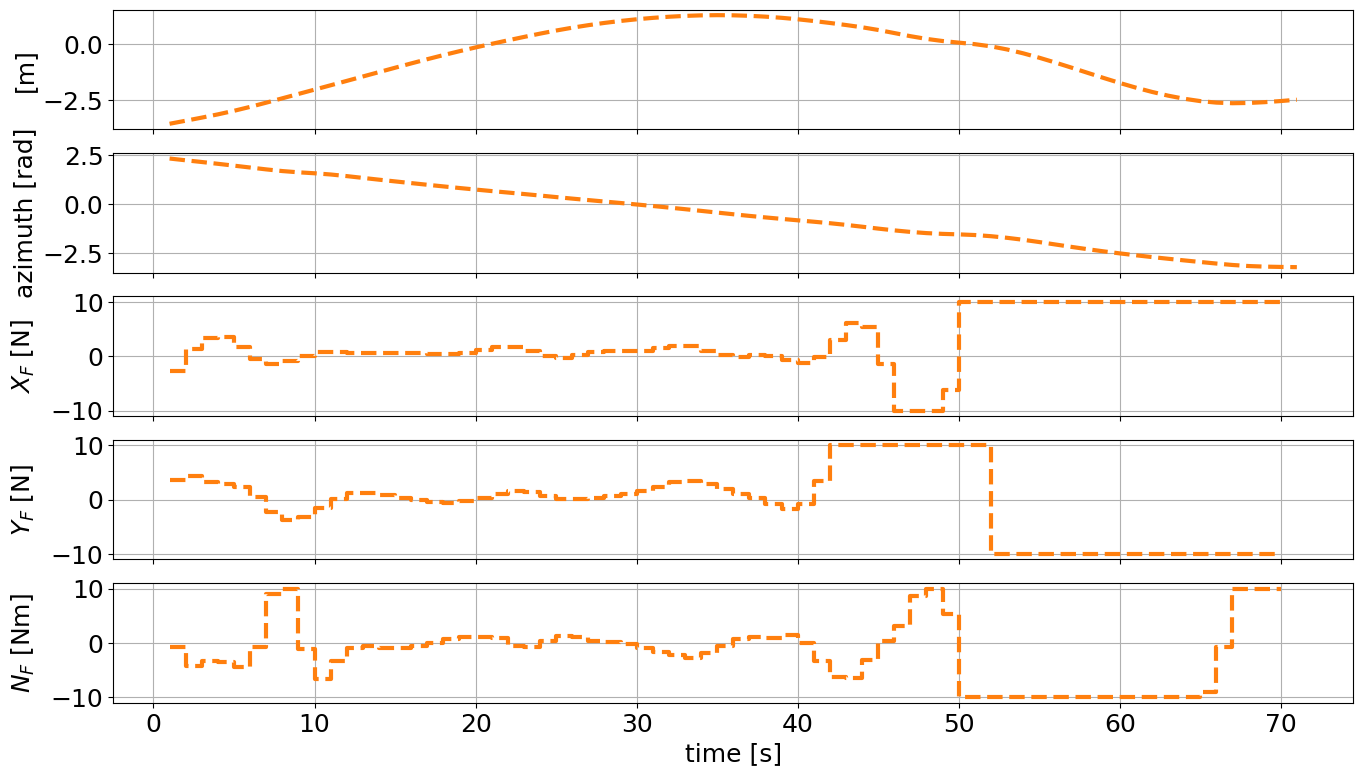

In [36]:
sim_graphics.clear()
mpc_graphics.plot_predictions()
mpc_graphics.reset_axes()
# Show the figure:
fig

In [37]:
simulator.reset_history()
simulator.x0 = x0
mpc.reset_history()

In [38]:
%%capture
for i in range(run_time):
    u0 = mpc.make_step(x0)
    x0 = simulator.make_step(u0)

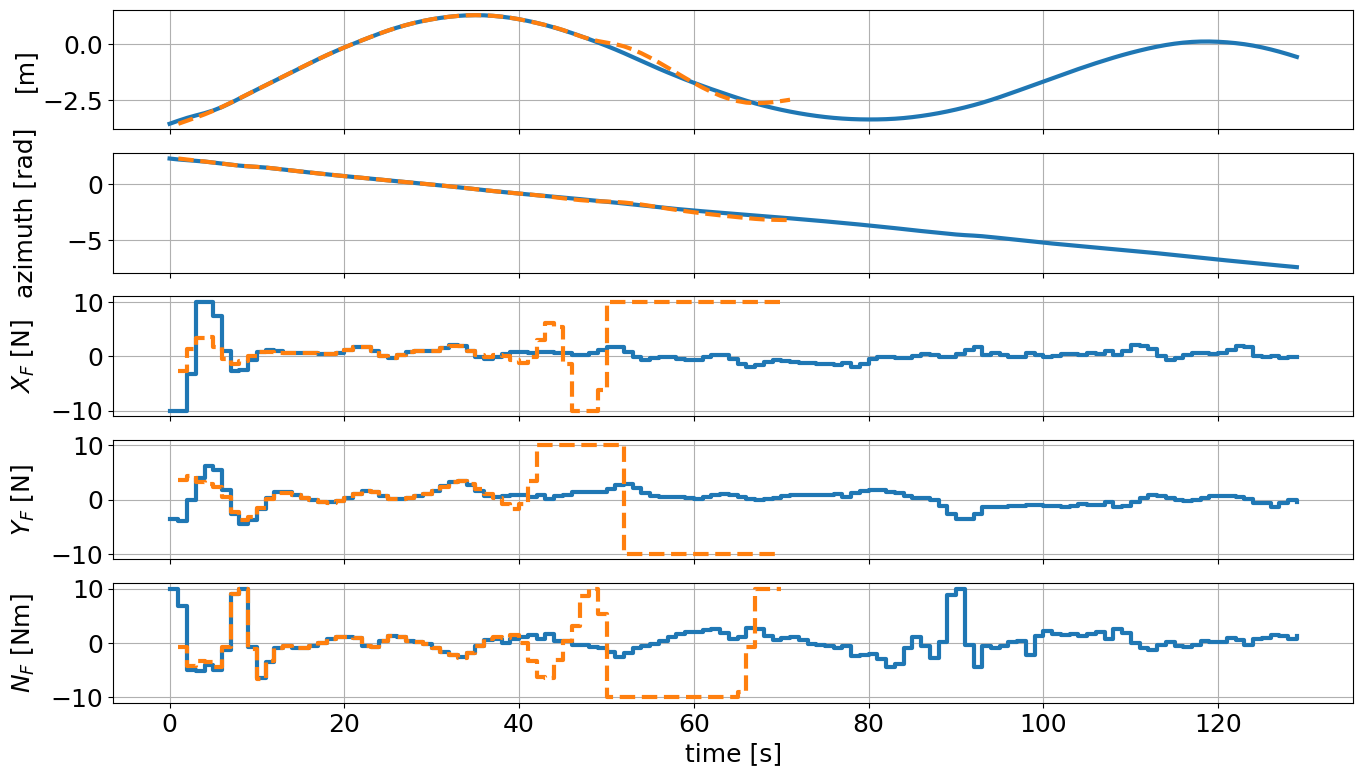

In [39]:
sim_graphics.clear()
mpc_graphics.clear()

sim_graphics.plot_results()
sim_graphics.reset_axes()
fig

青線はシミュレータで得られた船の軌道・船首角・舵角の時間変化  
黄色の線はt=0の時の予測の船の軌道・船首角・舵角の時間変化

In [40]:
# remove past results
import os
if os.path.exists("./results/results.pkl"):
    print("remove results.pkl")
    os.remove("./results/results.pkl")
# save present result
from do_mpc.data import save_results, load_results
save_results([mpc, simulator])
results = load_results('./results/results.pkl')

remove results.pkl


In [41]:
results['simulator']['_x'].shape

(130, 9)

## ship3DoFを使って可視化

In [42]:
from shipmmg.ship_obj_3dof import ShipObj3dof
# ship_kt = ShipObj3dof(L=2.1905, B=0.3067)
ship_kt = ShipObj3dof(L=3.50, B=0.57)
ship_kt.time  = np.linspace(0.00, run_time*t_step, run_time)
ship_kt.u = results['simulator']['_x','u'].reshape(-1)
ship_kt.v = results['simulator']['_x','v'].reshape(-1)
ship_kt.r = results['simulator']['_x','r'].reshape(-1)
ship_kt.x = results['simulator']['_x','x'].reshape(-1)
ship_kt.y = results['simulator']['_x','y'].reshape(-1)
ship_kt.psi = results['simulator']['_x','ψ'].reshape(-1)
ship_kt.X_F = results['simulator']['_x','X_F_m'].reshape(-1)
ship_kt.Y_F = results['simulator']['_x','Y_F_m'].reshape(-1)
ship_kt.N_F = results['simulator']['_x','N_F_m'].reshape(-1)

ship_kt.x_ref=results['mpc']['_tvp','x_ref'].reshape(-1)
ship_kt.y_ref=results['mpc']['_tvp','y_ref'].reshape(-1)
ship_kt.psi_ref=results['mpc']['_tvp','psi_ref'].reshape(-1)
ship_kt.u_ref=results['mpc']['_tvp','u_ref'].reshape(-1)
ship_kt.v_ref=results['mpc']['_tvp','v_ref'].reshape(-1)
ship_kt.r_ref=results['mpc']['_tvp','r_ref'].reshape(-1)

## 制御量(X_F, Y_F, N_F)　結果

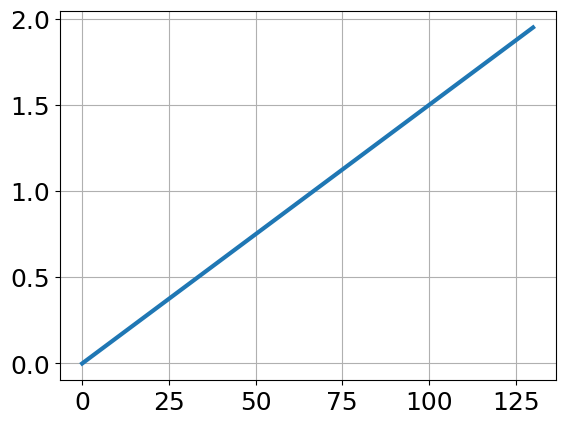

In [43]:
X_F0_initial = 0.0
X_F0_final = 1.5
X_F0 = X_F0_initial + (X_F0_final - X_F0_initial)/100 * ship_kt.time
plt.plot(ship_kt.time, X_F0)

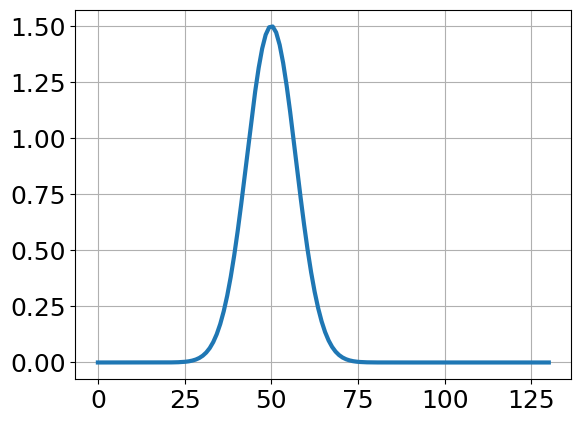

In [44]:
result = 1.5*np.exp(-(ship_kt.time-50)**2/100)
plt.plot(ship_kt.time, result)

C:\Users\yamamoto\AppData\Local\Temp\ipykernel_3196\162923460.py:66: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\yamamoto\AppData\Local\Temp\ipykernel_3196\162923460.py:75: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


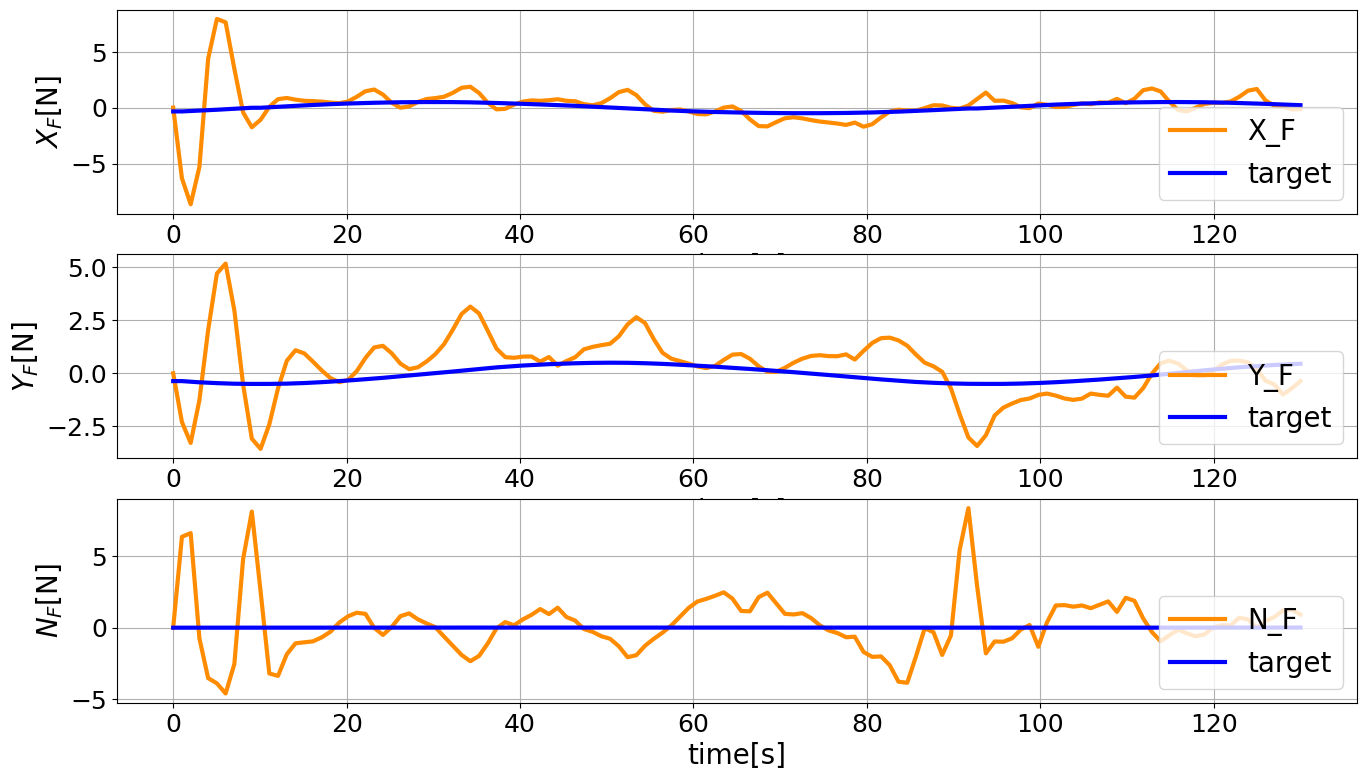

In [45]:
# 外力が常に一定の場合
X_F0 = np.ones(run_time) * 0.5
Y_F0 = np.ones(run_time) * 0

# 線形に外力が変化する場合
# x_f0_initial = 0.0
# x_f0_final = 3.0
# X_F0 = x_f0_initial + (x_f0_final - x_f0_initial) / 150 * ship_kt.time
# Y_F0 = np.ones(run_time) * 0

# 外力がガウス分布に従う場合
# X_F0 = 3.0 * np.exp(-(ship_kt.time-75)**2/100)
# Y_F0 = np.ones(run_time) * 0

X_F = list(
    map(
        lambda X_F0, Y_F0, psi:
        X_F0 * np.cos(psi) + Y_F0 * np.sin(psi)
        ,
        X_F0,
        Y_F0,
        ship_kt.psi_ref
    )
)
Y_F = list(
    map(
        lambda X_F0, Y_F0, psi:
        -X_F0 * np.sin(psi) + Y_F0 * np.cos(psi)
        ,
        X_F0,
        Y_F0,
        ship_kt.psi_ref
    )
)
N_F = list(map(lambda y: y * np.abs(x_G), Y_F))


fig = plt.figure(figsize=(16, 9))
ax1 = fig.add_subplot(3, 1, 1)
ax1.plot(ship_kt.time, ship_kt.X_F, label='X_F', c='darkorange')
ax1.plot(ship_kt.time, X_F, label='target', c='b')
ax1.set_xlabel('time[s]', fontsize=20)
ax1.set_ylabel('$X_F$[N]', fontsize=20)
# ax1.set_ylim(-10,10)
ax1.legend(frameon=True, loc='lower right', fontsize=20)

ax2 = fig.add_subplot(3, 1, 2)
ax2.plot(ship_kt.time, ship_kt.Y_F, label='Y_F', c='darkorange')
ax2.plot(ship_kt.time, Y_F, label='target', c='b')
ax2.set_xlabel('time[s]', fontsize=20)
ax2.set_ylabel('$Y_F$[N]', fontsize=20)
# ax2.set_ylim(-10,10)
ax2.legend(frameon=True, loc='lower right', fontsize=20)
fig.show()

ax3 = fig.add_subplot(3, 1, 3)
ax3.plot(ship_kt.time, ship_kt.N_F, label='N_F', c='darkorange')
ax3.plot(ship_kt.time, N_F, label='target', c='b')
ax3.set_xlabel('time[s]', fontsize=20)
ax3.set_ylabel('$N_F$[N]', fontsize=20)
# ax3.set_ylim(-10,10)
ax3.legend(frameon=True, loc='lower right', fontsize=20)
fig.show()

### 空間固定座標系に変換

C:\Users\yamamoto\AppData\Local\Temp\ipykernel_3196\4089308989.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\yamamoto\AppData\Local\Temp\ipykernel_3196\4089308989.py:46: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


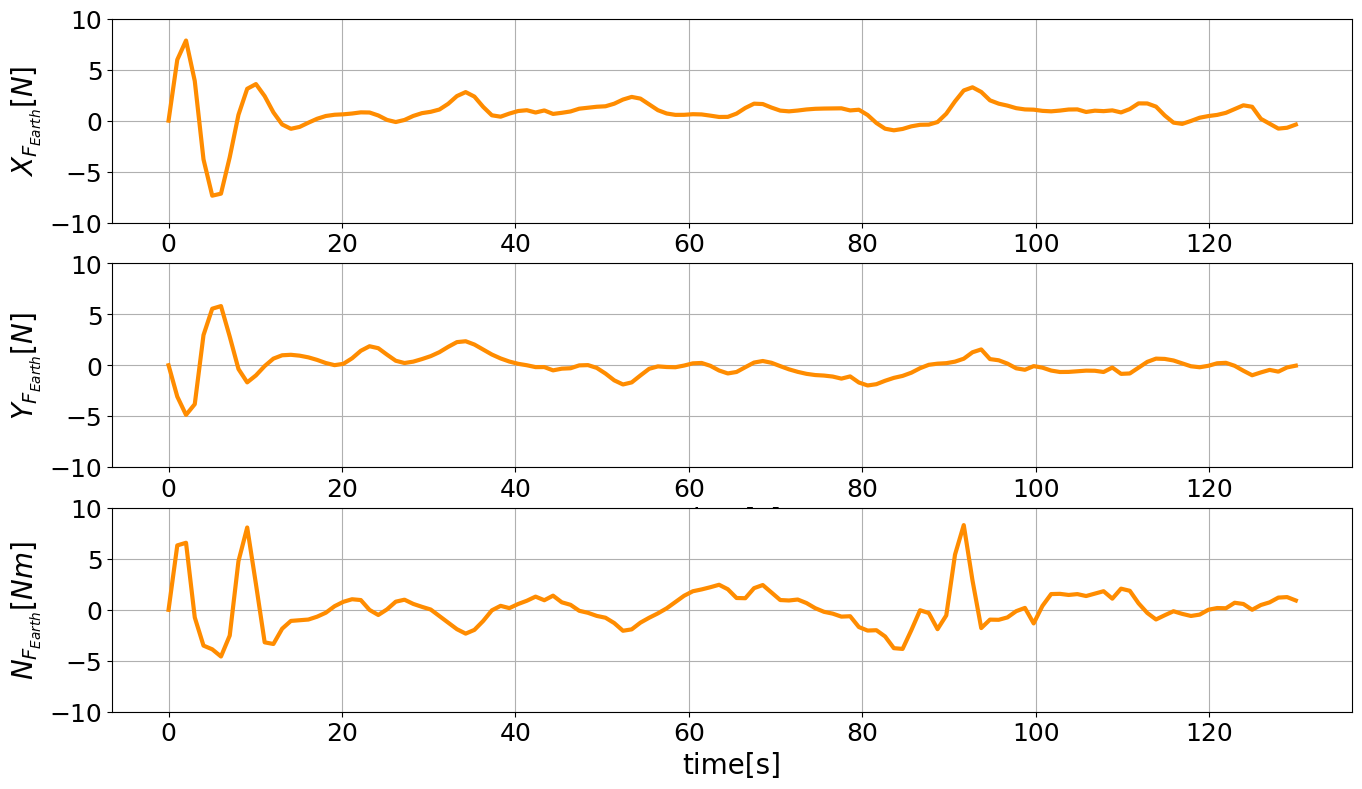

In [47]:
x_F = list(
    map(
        lambda X_F, Y_F, psi:
        X_F * np.cos(psi) - Y_F * np.sin(psi)
        ,
        ship_kt.X_F,
        ship_kt.Y_F,
        ship_kt.psi_ref,
    )
)
y_F = list(
    map(
        lambda X_F, Y_F, psi:
        X_F * np.sin(psi) + Y_F * np.cos(psi)
        ,
        ship_kt.X_F,
        ship_kt.Y_F,
        ship_kt.psi_ref,
    )
)
fig = plt.figure(figsize=(16, 9))
ax1 = fig.add_subplot(3, 1, 1)
ax1.plot(ship_kt.time, x_F, c='darkorange')
# ax1.plot(ship_kt.time, X_F0, label='target', c='b')
ax1.set_xlabel('time[s]', fontsize=20)
ax1.set_ylabel('$X_{F_{Earth}}[N]$', fontsize=20)
ax1.set_ylim(-10,10)
# ax1.legend(frameon=True, loc='lower right', fontsize=20)

ax2 = fig.add_subplot(3, 1, 2)
ax2.plot(ship_kt.time, y_F, c='darkorange')
# ax2.plot(ship_kt.time, Y_F0, label='target', c='b')
ax2.set_xlabel('time[s]', fontsize=20)
ax2.set_ylabel('$Y_{F_{Earth}}[N]$', fontsize=20)
ax2.set_ylim(-10,10)
# ax2.legend(frameon=True, loc='lower right', fontsize=20)
fig.show()

ax3 = fig.add_subplot(3, 1, 3)
ax3.plot(ship_kt.time, ship_kt.N_F, c='darkorange')
# ax3.plot(ship_kt.time, N_F, label='target', c='b')
ax3.set_xlabel('time[s]', fontsize=20)
ax3.set_ylabel('$N_{F_{Earth}}[Nm]$', fontsize=20)
ax3.set_ylim(-10,10)
# ax3.legend(frameon=True, loc='lower right', fontsize=20)
fig.show()

C:\Users\yamamoto\AppData\Local\Temp\ipykernel_3196\3933342931.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\yamamoto\AppData\Local\Temp\ipykernel_3196\3933342931.py:45: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\yamamoto\AppData\Local\Temp\ipykernel_3196\3933342931.py:53: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


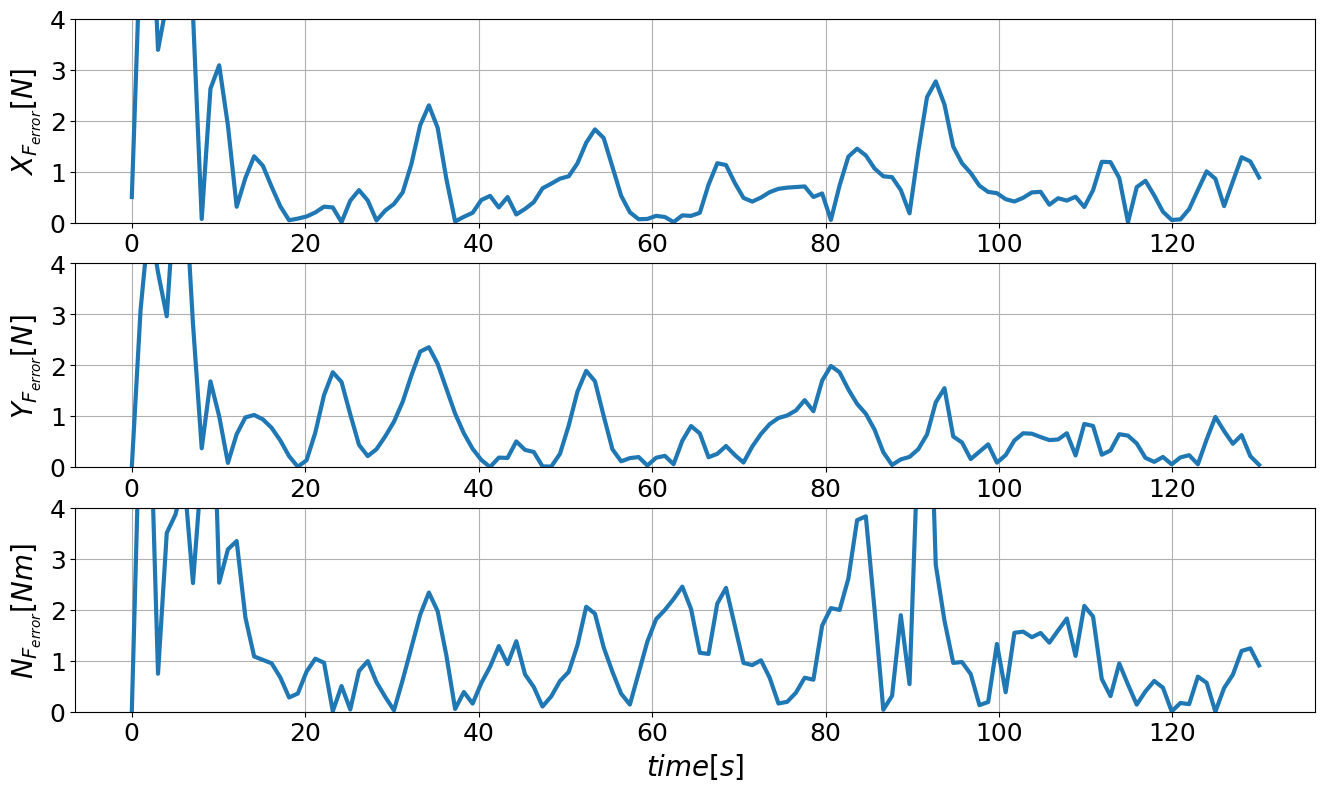

In [52]:
t = np.linspace(0, run_time, run_time)

max_d=0
index=0
e1=[]
e2=[]
e3=[]

e4=[]
e5=[]
e6=[]

e7=[]
e8=[]
e9=[]
for i in range(run_time):
    e1.append(np.sqrt((X_F[i]-ship_kt.X_F[i])**2) / np.abs(X_F[i]) * 100)
    e2.append(np.sqrt((Y_F[i]-ship_kt.Y_F[i])**2) / np.abs(Y_F[i]) * 100)
    e3.append(np.sqrt((N_F[i]-ship_kt.N_F[i])**2) / np.abs(N_F[i]) * 100)
    e4.append(np.abs(X_F0[i]-x_F[i]))
    e5.append(np.abs(Y_F0[i]-y_F[i]))
    e6.append(np.abs(N_F[i]-ship_kt.N_F[i]))
    e7.append(np.sqrt((X_F0[i]-x_F[i])**2))
    e8.append(np.sqrt((Y_F0[i]-y_F[i])**2))
    e9.append(np.sqrt((N_F[i]-ship_kt.N_F[i])**2))
    # e4.append(np.abs(X_F[i]-ship_kt.X_F[i]))
    # e5.append(np.abs(Y_F[i]-ship_kt.Y_F[i]))
    # e6.append(np.abs(N_F[i]-ship_kt.N_F[i]))

fig=plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(3, 1, 1)
# ax1.plot(t,e1)
ax1.plot(t,e4)
ax1.set_xlabel('$time[s]$')
ax1.set_ylabel('$X_{F_{error}}[N]$', fontsize=20)
ax1.set_ylim([0, 4])
fig.show()

ax2 = fig.add_subplot(3, 1, 2)
# ax2.plot(t,e2)
ax2.plot(t,e5)
ax2.set_xlabel('$time[s]$')
ax2.set_ylabel('$Y_{F_{error}}[N]$', fontsize=20)
ax2.set_ylim([0, 4])
fig.show()

ax3 = fig.add_subplot(3, 1, 3)
# ax3.plot(t,e3)
ax3.plot(t,e6)
ax3.set_xlabel('$time[s]$', fontsize=20)
ax3.set_ylabel('$N_{F_{error}}[Nm]$', fontsize=20)
ax3.set_ylim([0, 4])
fig.show()

In [53]:
e7_MSE = np.sum(e7[60:150])/90
e8_MSE = np.sum(e8[60:150])/90
e9_MSE = np.sum(e9[60:150])/90
print(f'X_F_error: {e7_MSE}, Y_F_error: {e8_MSE}, N_F_error: {e9_MSE}')

X_F_error: 0.5718889562316605, Y_F_error: 0.45470064835720536, N_F_error: 1.0504476651159689


c:\Users\yamamoto\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib_inline\backend_inline.py:27: UserWarning: The Figure parameters 'tight_layout' and 'constrained_layout' cannot be used together. Please use 'layout' parameter
  return new_figure_manager_given_figure(num, FigureClass(*args, **kwargs))


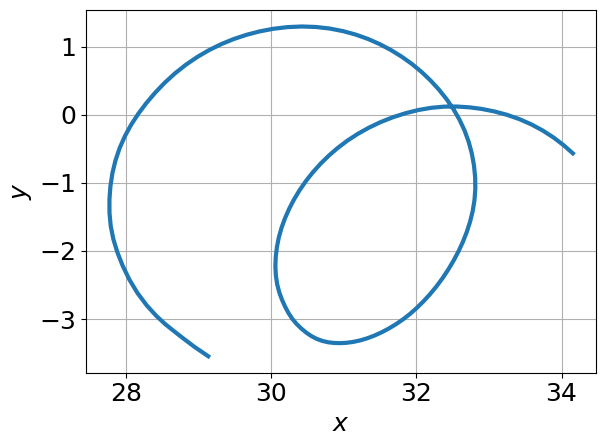

In [54]:
ship_kt.draw_xy_trajectory(aspect_equal=False)

### 実際に制御された軌道・方位角・舵角の表示

シミュレーションによって得られた軌道・方位角・舵角のみを表示するように抽出  
軌道には目標軌道も載せる

In [56]:
x_ref=list(ship_kt.x_ref)
y_ref=list(ship_kt.y_ref)
x=list(ship_kt.x)
y=list(ship_kt.y)
ψ=list(ship_kt.psi) 
u=list(ship_kt.u)
v=list(ship_kt.v)
r=list(ship_kt.r)
u_ref=list(ship_kt.u_ref)
v_ref=list(ship_kt.v_ref)
r_ref=list(ship_kt.r_ref)
# psi_ref=list(ship_kt.psi_ref)

### 時刻による誤差の表示

時刻$t$における誤差は$\sqrt{(x_t-x^{ref}_t)^2+(y_t-y^{ref}_t)^2}$で与えられるとして誤差を計算し、表示した。

C:\Users\yamamoto\AppData\Local\Temp\ipykernel_3196\2959644592.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\yamamoto\AppData\Local\Temp\ipykernel_3196\2959644592.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\yamamoto\AppData\Local\Temp\ipykernel_3196\2959644592.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\yamamoto\AppData\Local\Temp\ipykernel_3196\2959644592.py:45: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


0.23065372945846777 1


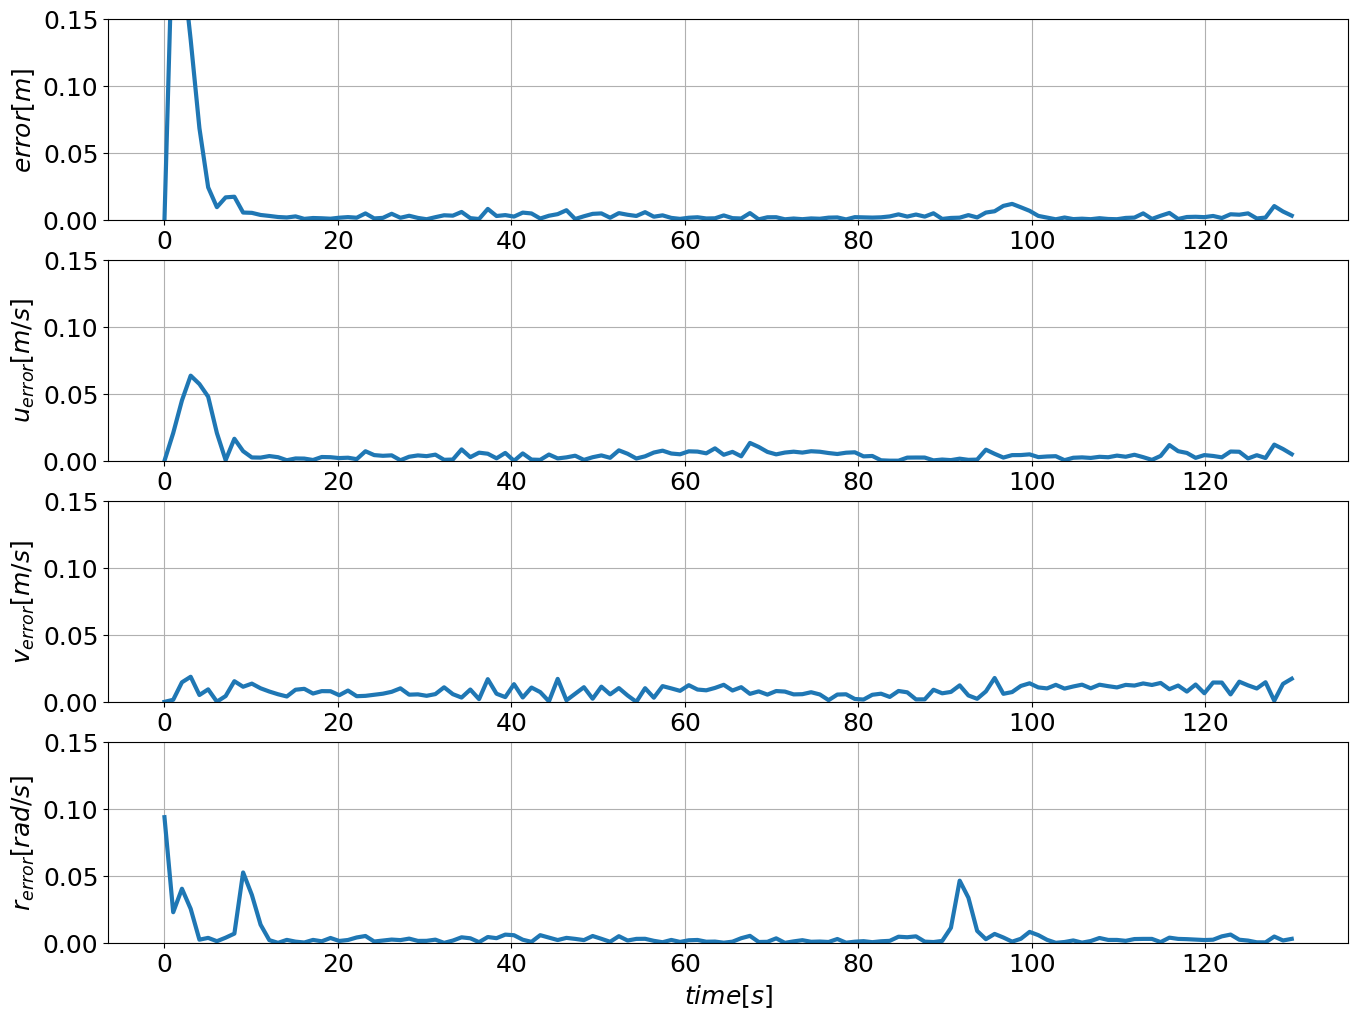

In [57]:
t = np.linspace(0, run_time, run_time)

max_d=0
index=0
e1=[]
e2=[]
e3=[]
e4=[]
for i in range(run_time):
    e1.append(np.sqrt((x[i]-x_ref[i])**2+(y[i]-y_ref[i])**2))
    e2.append(np.sqrt((u[i]-u_ref[i])**2))
    e3.append(np.sqrt((v[i]-v_ref[i])**2))
    e4.append(np.sqrt((r[i]-r_ref[i])**2))
    if max_d<np.sqrt((x[i]-x_ref[i])**2+(y[i]-y_ref[i])**2):
        max_d=np.sqrt((x[i]-x_ref[i])**2+(y[i]-y_ref[i])**2)
        index=i
print(max_d,index)
fig=plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(4, 1, 1)
ax1.plot(t,e1)
ax1.set_xlabel('$time[s]$')
ax1.set_ylabel('$error[m]$')
ax1.set_ylim([0, 0.15])
fig.show()

ax2 = fig.add_subplot(4, 1, 2)
ax2.plot(t,e2)
ax2.set_xlabel('$time[s]$')
ax2.set_ylabel('$u_{error}[m/s]$')
ax2.set_ylim([0, 0.15])
fig.show()

ax3 = fig.add_subplot(4, 1, 3)
ax3.plot(t,e3)
ax3.set_xlabel('$time[s]$')
ax3.set_ylabel('$v_{error}[m/s]$')
ax3.set_ylim([0, 0.15])
fig.show()

ax4 = fig.add_subplot(4, 1, 4)
ax4.plot(t,e4)
ax4.set_xlabel('$time[s]$')
ax4.set_ylabel('$r_{error}[rad/s]$')
ax4.set_ylim([0, 0.15])
fig.show()
# plt.ylim([0, 0.15])
# plt.show()

0.23065372945846777 1


C:\Users\yamamoto\AppData\Local\Temp\ipykernel_3196\260844898.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\yamamoto\AppData\Local\Temp\ipykernel_3196\260844898.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\yamamoto\AppData\Local\Temp\ipykernel_3196\260844898.py:41: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\yamamoto\AppData\Local\Temp\ipykernel_3196\260844898.py:49: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


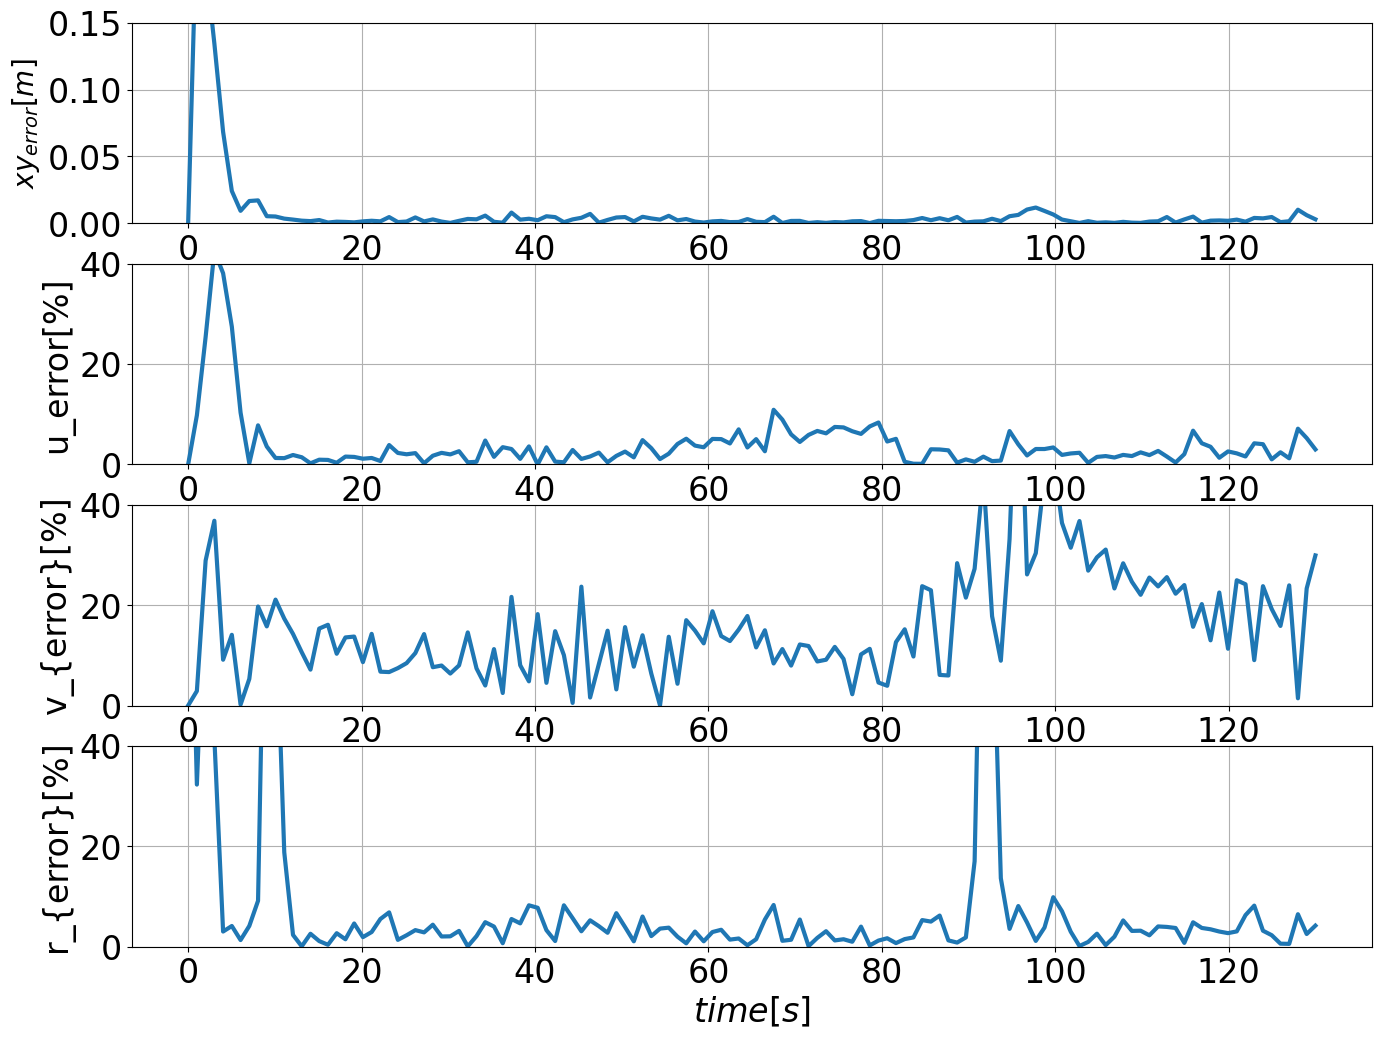

In [58]:
t = np.linspace(0, run_time, run_time)

max_d=0
index=0
e1=[]
e2=[]
e3=[]
e4=[]
for i in range(run_time):
    e1.append(np.sqrt((x[i]-x_ref[i])**2+(y[i]-y_ref[i])**2))
    e2.append(np.sqrt((u[i]-u_ref[i])**2) / np.abs(u[i]) * 100)
    e3.append(np.sqrt((v[i]-v_ref[i])**2) / np.abs(v[i]) * 100)
    e4.append(np.sqrt((r[i]-r_ref[i])**2) / np.abs(r[i]) * 100)
    if max_d<np.sqrt((x[i]-x_ref[i])**2+(y[i]-y_ref[i])**2):
        max_d=np.sqrt((x[i]-x_ref[i])**2+(y[i]-y_ref[i])**2)
        index=i
print(max_d,index)
fig=plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(4, 1, 1)
ax1.plot(t,e1)
ax1.set_xlabel('$time[s]$')
ax1.set_ylabel('$xy_{error}[m]$', fontsize=20)
ax1.set_ylim([0, 0.15])
plt.tick_params(labelsize=24)
fig.show()

ax2 = fig.add_subplot(4, 1, 2)
ax2.plot(t,e2)
ax2.set_xlabel('$time[s]$')
ax2.set_ylabel('u_error[%]', fontsize=24)
ax2.set_ylim([0, 40])
plt.tick_params(labelsize=24)
fig.show()

ax3 = fig.add_subplot(4, 1, 3)
ax3.plot(t,e3)
ax3.set_xlabel('$time[s]$')
ax3.set_ylabel('v_{error}[%]', fontsize=24)
ax3.set_ylim([0, 40])
plt.tick_params(labelsize=24)
fig.show()

ax4 = fig.add_subplot(4, 1, 4)
ax4.plot(t,e4)
ax4.set_xlabel('$time[s]$', fontsize=24)
ax4.set_ylabel('r_{error}[%]', fontsize=24)
ax4.set_ylim([0, 40])
plt.tick_params(labelsize=24)
fig.show()
# plt.ylim([0, 0.15])
# plt.show()

## 目標軌道とsimulationとの比較
この回の軌道と実際にsimulationで得られた軌道の比較をする

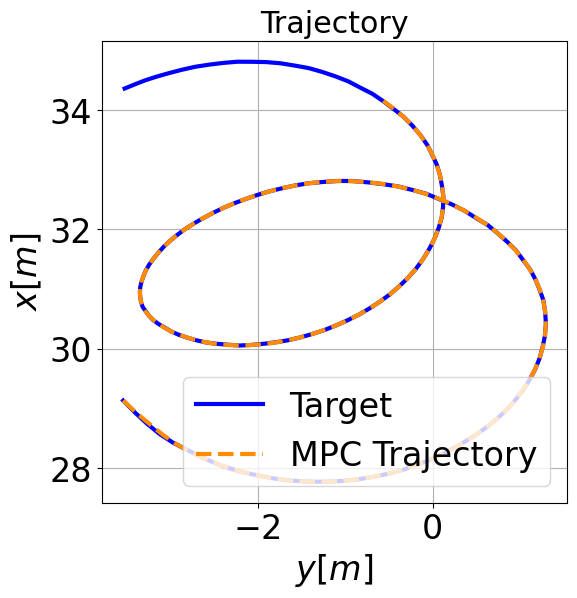

In [59]:
fig=plt.figure(figsize=(6.0, 6.0))
plt.plot(csv_input['y'][0:150],csv_input['x'][0:150],label="Target", c='b')
plt.plot(y,x,label="MPC Trajectory", c='darkorange', linestyle='dashed')
# plt.plot(csv_input['y'],csv_input['x'],label="target", c='b')
# # plt.plot(y,x,label="Trajectory", c='b')
# plt.plot(y_ref,x_ref,label="Trajectory",linestyle="dashed", c='darkorange')
plt.title("Trajectory")
plt.legend(loc='lower right', fontsize=24)
plt.xlabel('$y[m]$', fontsize=24)
plt.ylabel('$x[m]$', fontsize=24)
plt.tick_params(labelsize=24)
# plt.xlim(-0.5, 8)
# plt.ylim(-0.5, 8)
plt.show()


In [122]:
class DrawObj():
    def __init__(self, ax):
        self.ax = ax
        self.img = []
        self.img2 = []
        self.img.append(ax.plot([], [], color="b", alpha=0.8))
        self.img.append(ax.plot([], [], color="y"))
        self.img2.append(ax.plot([], [], color="darkorange"))
        self.img2.append(ax.plot([], [], color="y"))
        # self.img.append(ax.plot([], [], color="darkorange", linestyle="dashed"))
        # self.img.append(ax.plot([], [], color="y"))
        # self.img2.append(ax.plot([], [], color="b", alpha=0.8))
        # self.img2.append(ax.plot([], [], color="y"))

    def draw_square_with_angle(self, center_x_list, center_y_list, shape_list, angle_list):
        for i in range(len(shape_list)):
            square_x, square_y, angle_x, angle_y = self.square_with_angle(center_x_list[i], center_y_list[i], shape_list[i], angle_list[i])
            self.img[i][0].set_xdata(square_x)
            self.img[i][0].set_ydata(square_y)
        return self.img

    def draw_square_with_angle2(self, center_x_list2, center_y_list2, shape_list2, angle_list2):
        for i in range(len(shape_list2)):
            square_x2, square_y2, angle_2, angle_y2 = self.square_with_angle2(center_x_list2[i], center_y_list2[i], shape_list2[i], angle_list2[i])
            self.img2[i][0].set_xdata(square_x2)
            self.img2[i][0].set_ydata(square_y2)
        return self.img2

    def rotate_pos(self, pos, angle):
        rot_mat = np.array([[np.cos(angle), -np.sin(angle)],
                            [np.sin(angle), np.cos(angle)]])

        return np.dot(pos, rot_mat.T)

    def rotate_pos2(self, pos2, angle2):
        rot_mat2 = np.array([[np.cos(angle2), -np.sin(angle2)],
                            [np.sin(angle2), np.cos(angle2)]])

        return np.dot(pos2, rot_mat2.T)

    def square(self, center_x, center_y, shape, angle):
        """ Create square
        Args:
            center_x (float): the center x position of the square
            center_y (float): the center y position of the square
            shape (tuple): the square's shape(width/2, height/2)
            angle (float): in radians
        Returns: 
            square_x (numpy.ndarray): shape(5, ), counterclockwise from right-up
            square_y (numpy.ndarray): shape(5, ), counterclockwise from right-up
        """
        # start with the up right points
        # create point in counterclockwise, local
        square_xy = np.array([[shape[0], shape[1]],
                              [-shape[0], shape[1]],
                              [-shape[0], -shape[1]],
                              [shape[0], -shape[1]],
                              [shape[0], shape[1]]])

        # translate position to world
        # rotation
        trans_points = self.rotate_pos(square_xy, angle)
        # translation
        trans_points += np.array([center_x, center_y])

        return trans_points[:, 0], trans_points[:, 1]
    
    def square2(self, center_x2, center_y2, shape2, angle2):
        square_xy2 = np.array([[shape2[0], shape2[1]],
                              [-shape2[0], shape2[1]],
                              [-shape2[0], -shape2[1]],
                              [shape2[0], -shape2[1]],
                              [shape2[0], shape2[1]]])

        # translate position to world
        # rotation
        trans_points2 = self.rotate_pos2(square_xy2, angle2)
        # translation
        trans_points2 += np.array([center_x2, center_y2])

        return trans_points2[:, 0], trans_points2[:, 1]
        
    
    def square_with_angle(self,center_x, center_y, shape, angle):
        """ Create square with angle line
        Args:    
            center_x (float): the center x position of the square
            center_y (float): the center y position of the square
            shape (tuple): the square's shape(width/2, height/2)
            angle (float): in radians
        Returns: 
            square_x (numpy.ndarray): shape(5, ), counterclockwise from right-up
            square_y (numpy.ndarray): shape(5, ), counterclockwise from right-up
            angle_x (numpy.ndarray): x data of square angle
            angle_y (numpy.ndarray): y data of square angle
        """
        square_x, square_y = self.square(center_x, center_y, shape, angle)

        angle_x = np.array([center_x, center_x + np.cos(angle) * shape[0]])
        angle_y = np.array([center_y, center_y + np.sin(angle) * shape[1]])

        return square_x, square_y, angle_x, angle_y
    
    def square_with_angle2(self,center_x2, center_y2, shape2, angle2):
        
        square_x2, square_y2 = self.square2(center_x2, center_y2, shape2, angle2)
        angle_x2 = np.array([center_x2, center_x2 + np.cos(angle2) * shape2[0]])
        angle_y2 = np.array([center_y2, center_y2 + np.sin(angle2) * shape2[1]])

        return square_x2, square_y2, angle_x2, angle_y2
    
def update_obj(i, x_list, y_list, shape_list, ψ_list, x_list2, y_list2, shape_list2, ψ_list2, frate):
    j = int(frate*i)
    plt.title(r'$t$ = ' + '{:.1f}'.format(time_list[j]))
    
    xT = np.array(x_list).T
    _x_list_j = list(xT[j].T)
    yT = np.array(y_list).T
    _y_list_j = list(yT[j].T)
    ψT = np.array(ψ_list).T
    _ψ_list_j = list(ψT[j].T)
    
    xT2 = np.array(x_list2).T
    _x_list_j2 = list(xT2[j].T)
    yT2 = np.array(y_list2).T
    _y_list_j2 = list(yT2[j].T)
    ψT2 = np.array(ψ_list2).T
    _ψ_list_j2 = list(ψT2[j].T)
    
    # return drawer.draw_square_with_angle(_x_list_j, _y_list_j,shape_list,_ψ_list_j),drawer.draw_square_with_angle2(_x_list_j2, _y_list_j2,shape_list2,_ψ_list_j2)
    return drawer.draw_square_with_angle(_x_list_j, _y_list_j,shape_list,_ψ_list_j)
    # return drawer.draw_square_with_angle2(_x_list_j2, _y_list_j2,shape_list2,_ψ_list_j2), drawer.draw_square_with_angle(_x_list_j, _y_list_j,shape_list,_ψ_list_j)


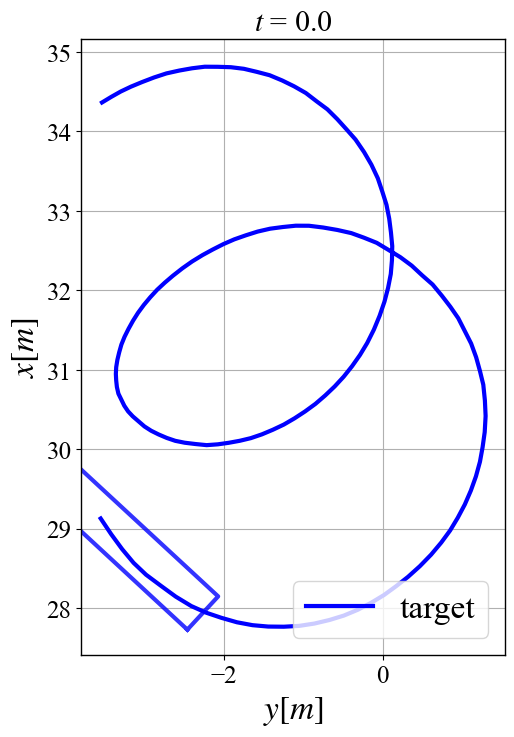

In [115]:
from matplotlib.animation import FuncAnimation
time_list = ship_kt.time
fig=plt.figure(figsize=(8.0,8.0))
ax = fig.add_subplot(111)
x_ref=csv_input['x'][0:150]
y_ref=csv_input['y'][0:150]
psi_ref=-csv_input['psi'][0:150] # 
psi = ship_kt.psi * (-1)

plt.plot(y_ref,x_ref,label="target", c='b')
plt.plot(y,x,label="Trajectory", c='darkorange', linestyle='dashed')
# plt.plot(x_ref,y_ref,label="target", c='b')
# plt.plot(x,y,label="Trajectory", c='darkorange', linestyle='dashed')
plt.legend(loc='lower right', fontsize=24)
ax.set_xlabel('$y[m]$', fontsize=24)
ax.set_ylabel('$x[m]$', fontsize=24)
ax.set_aspect('equal')

drawer=DrawObj(ax)

frate=1.0
frames=int(time_list[-1]/frate)

ani1=FuncAnimation(fig, update_obj, fargs=([y], [x], [(B/2, L_pp/2)], [psi], [y_ref], [x_ref], [(B/2, L_pp/2)], [psi_ref], frate), interval=200, frames=frames)
# ani1=FuncAnimation(fig, update_obj, fargs=([y_ref], [x_ref], [(B/2, L_pp/2)], [psi_ref], [y], [x], [(B/2, L_pp/2)], [psi], frate), interval=200, frames=frames)
# ani1=FuncAnimation(fig, update_obj, fargs=([y], [x], [(L_pp/3, B/3)], [ship_kt.psi], [y_ref], [x_ref], [(L_pp/3, B/3)], [psi_ref], frate), interval=200, frames=frames)

ani1.save('ship_anim.gif', writer='pillow')

In [76]:
plt.rcParams['font.family'] = 'Times New Roman' #全体のフォントを設定
plt.rcParams["mathtext.fontset"] = "stix" # math fontの設定
plt.rcParams['axes.linewidth'] = 1.0# 軸の線幅edge linewidth。囲みの太さ

data_case2_142 = pd.read_csv('suzaku_data/suzaku_case2_est_0127_130_142.csv')
data_case2_130 = pd.read_csv('suzaku_data/suzaku_case2_est_0123_130.csv')

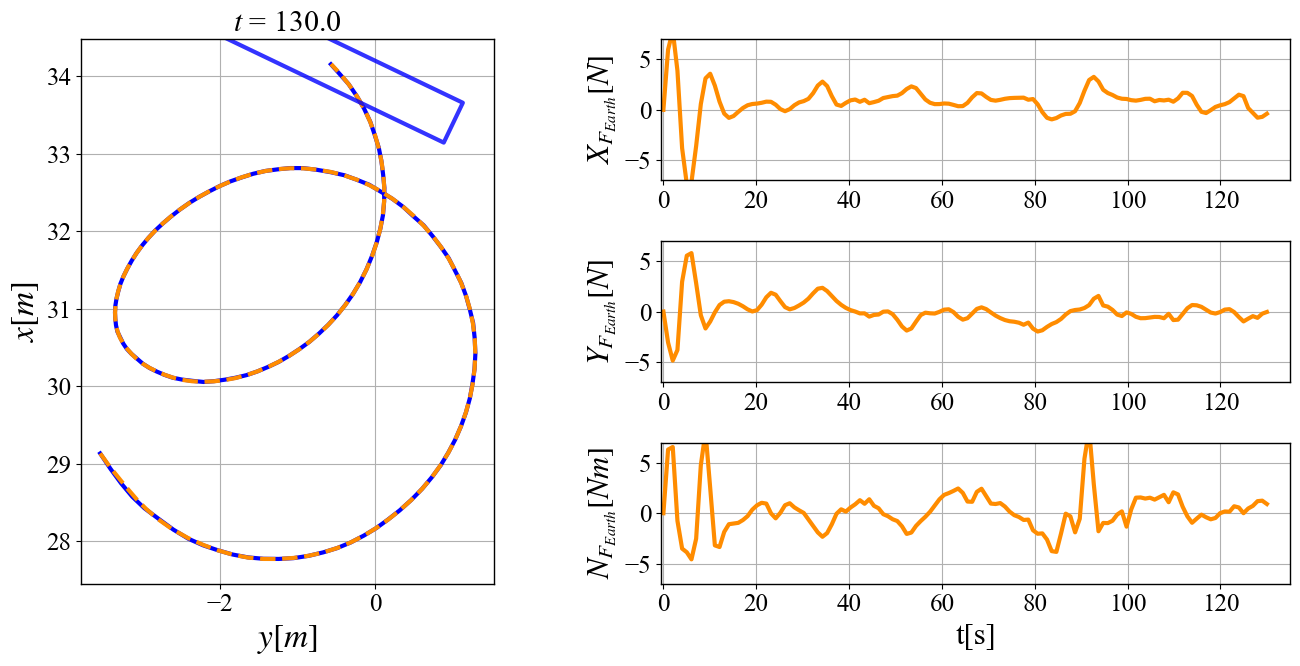

In [125]:
fig = plt.figure(figsize=(14, 7))

# 右半分のグラフ
plt.subplot(322)
plt.plot(data_case2_142['time'], data_case2_142['x_F'], c='darkorange')
plt.xlim(-0.5, 135)
plt.ylim(-7, 7)
plt.ylabel('$X_{F_{Earth}}[N]$', fontsize=22)
# plt.grid()

plt.subplot(324)
plt.plot(data_case2_142['time'], data_case2_142['y_F'], c='darkorange')
plt.xlim(-0.5, 135)
plt.ylim(-7, 7)
plt.ylabel('$Y_{F_{Earth}}[N]$', fontsize=22)
# plt.grid()

plt.subplot(326)
plt.plot(data_case2_142['time'], data_case2_142['n_F'], c='darkorange')
plt.xlim(-0.5, 135)
plt.ylim(-7, 7)
plt.ylabel('$N_{F_{Earth}}[Nm]$', fontsize=22)
plt.xlabel('t[s]', fontsize=22)
# plt.grid()

# 左半分のアニメーション
ax = plt.subplot(121)
x_ref = csv_input['x'][0:130]
y_ref = csv_input['y'][0:130]
psi_ref = -csv_input['psi'][0:130] 
psi = ship_kt.psi * (-1)

plt.plot(y_ref, x_ref, label="target", c='b')
plt.plot(y, x, label="Trajectory", c='darkorange', linestyle='dashed')
# plt.legend(loc='lower right', fontsize=24)
ax.set_xlabel('$y[m]$', fontsize=24)
ax.set_ylabel('$x[m]$', fontsize=24)
ax.set_aspect('equal')

drawer = DrawObj(ax)

frate = 1.0
frames = int(time_list[-1] / frate)

ani1 = FuncAnimation(fig, update_obj, fargs=([y], [x], [(B/2, L_pp/2)], [psi], [y_ref], [x_ref], [(B/2, L_pp/2)], [psi_ref], frate), interval=200, frames=frames)
ani1.save('ship_anim.gif', writer='pillow')
plt.tight_layout()
plt.show()

In [62]:
# ship_kt.draw_gif(frate=1, save_fig_path='MMG_MPC_demo01.gif')

C:\Users\yamamoto\AppData\Local\Temp\ipykernel_3196\4044273449.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\yamamoto\AppData\Local\Temp\ipykernel_3196\4044273449.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


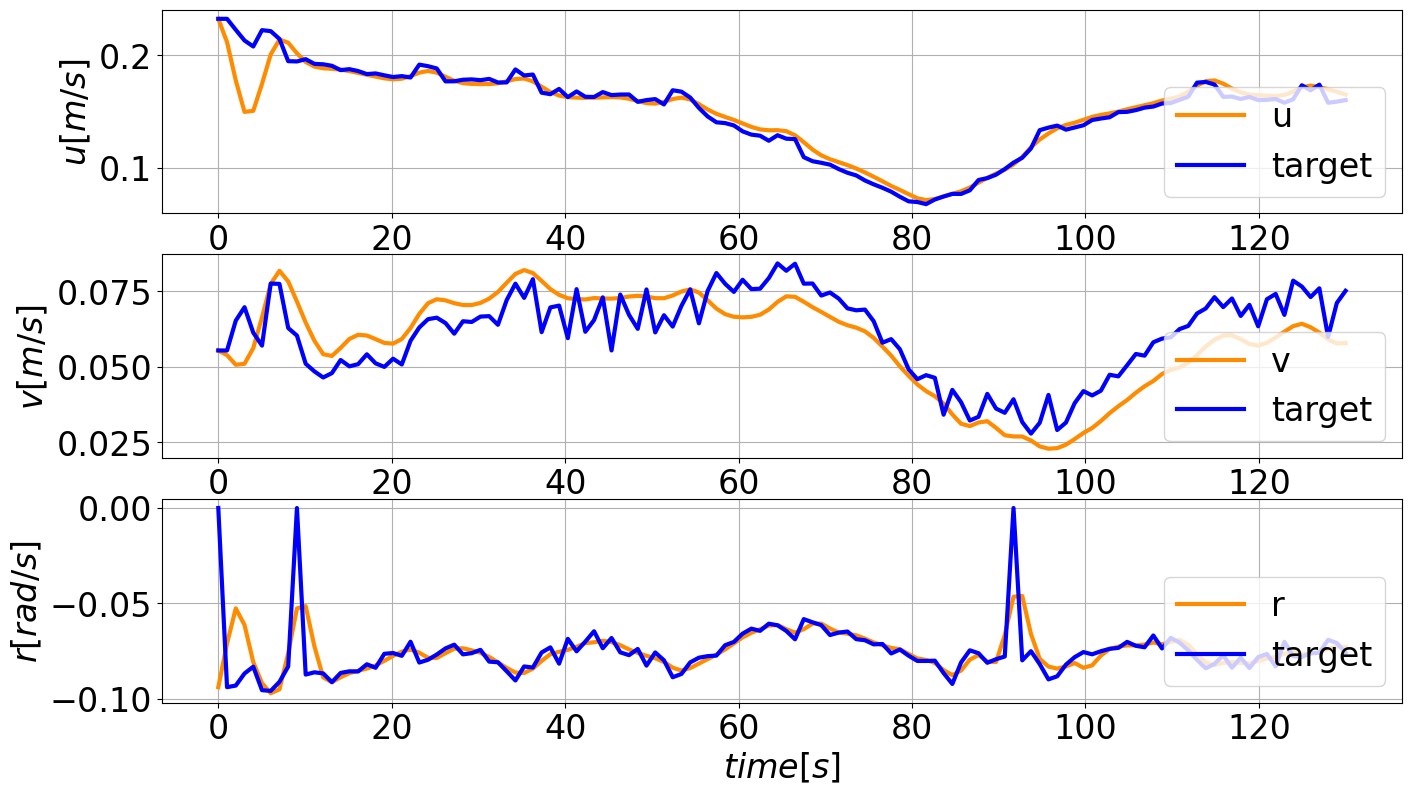

In [63]:
fig = plt.figure(figsize=(16, 9))
ax1 = fig.add_subplot(3, 1, 1)
ax1.plot(ship_kt.time, ship_kt.u, label='u', c='darkorange')
ax1.plot(ship_kt.time, ship_kt.u_ref, label='target', c='b')
ax1.set_xlabel('$time[s]$', fontsize=24)
ax1.set_ylabel('$u[m/s]$', fontsize=24)
plt.tick_params(labelsize=24)
# ax1.set_xlim([0, 100])
ax1.legend(frameon=True, loc='lower right', fontsize=24)

ax2 = fig.add_subplot(3, 1, 2)
ax2.plot(ship_kt.time, ship_kt.v, label='v', c='darkorange')
ax2.plot(ship_kt.time, ship_kt.v_ref, label='target', c='b')
ax2.set_xlabel('$time[s]$', fontsize=24)
ax2.set_ylabel('$v[m/s]$', fontsize=24)
plt.tick_params(labelsize=24)
# ax2.set_xlim([0, 100])
ax2.legend(frameon=True, loc='lower right', fontsize=24)
fig.show()

ax3 = fig.add_subplot(3, 1, 3)
ax3.plot(ship_kt.time, ship_kt.r, label='r', c='darkorange')
ax3.plot(ship_kt.time, ship_kt.r_ref, label='target', c='b')
ax3.set_xlabel('$time[s]$', fontsize=24)
ax3.set_ylabel('$r[rad/s]$', fontsize=24)
plt.tick_params(labelsize=24)
# ax3.set_xlim([0, 100])
ax3.legend(frameon=True, loc='lower right', fontsize=24)
fig.show()

### 船全体に加わる力に対する外力の割合

In [64]:
ship_kt.δ = csv_input['δ'][0:run_time]
ship_kt.npm = csv_input['npm'][0:run_time]
(
    X_H_list,
    X_R_list,
    X_P_list,
    Y_H_list,
    Y_R_list,
    N_H_list,
    N_R_list,
    U_list,
    β_list,
    v_dash_list,
    r_dash_list,
    β_P_list,
    w_P_list,
    J_list,
    K_T_list,
    β_R_list,
    γ_R_list,
    v_R_list,
    u_R_list,
    U_R_list,
    α_R_list,
    F_N_list,
) = get_sub_values_from_simulation_result(
    ship_kt.u, #u
    ship_kt.v, #v
    ship_kt.r, #r
    # csv_input['u'][0:150], #u
    # csv_input['v'][0:150], #v
    # csv_input['r'][0:150], #r
    ship_kt.δ, #δ
    ship_kt.npm, #npm
    basic_params,
    maneuvering_params,
    return_all_vals=True,
)
(
    X_H_ref_list,
    X_R_ref_list,
    X_P_ref_list,
    Y_H_ref_list,
    Y_R_ref_list,
    N_H_ref_list,
    N_R_ref_list,
    U_ref_list,
    β_ref_list,
    v_dash_ref_list,
    r_dash_ref_list,
    β_P_ref_list,
    w_P_ref_list,
    J_ref_list,
    K_T_ref_list,
    β_R_ref_list,
    γ_R_ref_list,
    v_R_ref_list,
    u_R_ref_list,
    U_R_ref_list,
    α_R_ref_list,
    F_N_ref_list,
) = get_sub_values_from_simulation_result(
    ship_kt.u_ref, #u
    ship_kt.v_ref, #v
    ship_kt.r_ref, #r
    # csv_input['u'][0:150], #u
    # csv_input['v'][0:150], #v
    # csv_input['r'][0:150], #r
    ship_kt.δ, #δ
    ship_kt.npm, #npm
    basic_params,
    maneuvering_params,
    return_all_vals=True,
)

In [67]:
X_ratio = list(
    map(
        lambda X_F, X_H, X_R, X_P:
        X_F / (X_H + X_R + X_P + X_F) * 100
        ,
        ship_kt.X_F,
        X_H_list,
        X_R_list,
        X_P_list,
    )
)

Y_ratio = list(
    map(
        lambda Y_F, Y_H, Y_R:
        Y_F / (Y_H + Y_R + Y_F) * 100
        ,
        ship_kt.Y_F,
        Y_H_list,
        Y_R_list,
    )
)

N_ratio = list(
    map(
        lambda N_F, N_H, N_R:
        N_F / (N_H + N_R + N_F) * 100
        ,
        ship_kt.N_F,
        N_H_list,
        N_R_list,
    )
)

In [68]:
X_total = list(
    map(
        lambda X_H, X_R, X_P:
        X_H + X_R + X_P
        ,
        X_H_list,
        X_R_list,
        X_P_list,
    )
)

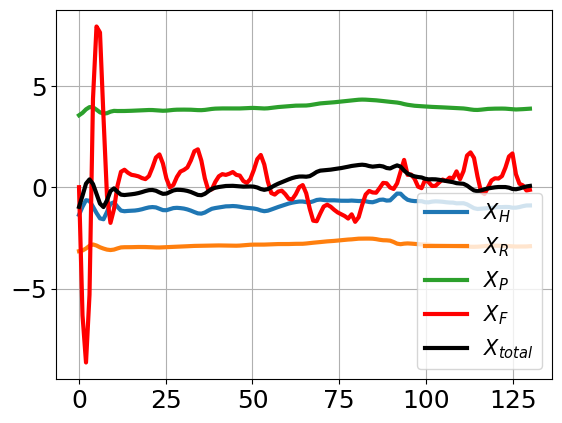

In [70]:
plt.plot(ship_kt.time, X_H_list, label='$X_{H}$')
plt.plot(ship_kt.time, X_R_list, label='$X_{R}$')
plt.plot(ship_kt.time, X_P_list, label='$X_{P}$')
plt.plot(ship_kt.time, ship_kt.X_F, c='r', label='$X_{F}$')
plt.plot(ship_kt.time, X_total, c='k', label='$X_{total}$')
plt.legend(fontsize='small')

#### データの保存

In [71]:
suzaku = pd.DataFrame({'time':ship_kt.time,
                        'u':ship_kt.u,
                        'v':ship_kt.v, 
                        'r':ship_kt.r, 
                        'x':ship_kt.x, 
                        'y':ship_kt.y, 
                        'psi':ship_kt.psi,  
                        'X_F':ship_kt.X_F, #船体座標系
                        'Y_F':ship_kt.Y_F,
                        'N_F':ship_kt.N_F,
                        'u_ref':ship_kt.u_ref,
                        'v_ref':ship_kt.v_ref,
                        'r_ref':ship_kt.r_ref,
                        'x_ref':ship_kt.x_ref,
                        'y_ref':ship_kt.y_ref,
                        'psi_ref':ship_kt.psi_ref,
                        'X_F_ref':X_F, #設定値（船体座標）
                        'Y_F_ref':Y_F,
                        'N_F_ref':N_F,
                        'x_F_ref':X_F0, #設定値（固定座標）
                        'y_F_ref':Y_F0,
                        'n_F_ref':N_F,
                        'x_F':x_F, # 固定座標系
                        'y_F':y_F,
                        'n_F':ship_kt.N_F, 
                        'X_H':X_H_list,
                        'X_R':X_R_list,
                        'X_P':X_P_list,
                        'Y_H':Y_H_list,
                        'Y_R':Y_R_list,
                        'N_H':N_H_list,
                        'N_R':N_R_list,
                        'X_H_ref':X_H_ref_list,
                        'X_R_ref':X_R_ref_list,
                        'X_P_ref':X_P_ref_list,
                        'Y_H_ref':Y_H_ref_list,
                        'Y_R_ref':Y_R_ref_list,
                        'N_H_ref':N_H_ref_list,
                        'N_R_ref':N_R_ref_list,
                        
})
# suzaku.to_csv('suzaku_data/suzaku_case2_est_0205_142.csv')

In [72]:
suzaku1 = pd.DataFrame({'time':ship_kt.time,
                        'u':ship_kt.u,
                        'v':ship_kt.v, 
                        'r':ship_kt.r, 
                        'x':ship_kt.x, 
                        'y':ship_kt.y, 
                        'psi':ship_kt.psi, 
                        'δ':ship_kt.δ,
                        'nps':ship_kt.npm, 
                        'X_F':ship_kt.X_F,
                        'Y_F':ship_kt.Y_F,
                        'N_F':ship_kt.N_F,
                        'x_ref':ship_kt.x_ref,
                        'y_ref':ship_kt.y_ref,
                        'x_F':x_F, # 船体座標系
                        'y_F':y_F,
                        'n_F':ship_kt.N_F, 
})
# suzaku1.to_csv('suzaku_data/suzaku_1EF_20deg_cfm.csv')